FTIR Peak Fitting for Bruker Hyperion 2000 FTIR Microscope (Also works for single spectra taken with Invenio)
put together by Jeff Roshko Summer 2022 to 2023

This notebook is based on a previously developed code demonstrating spectral deconvolution using the FTIR tool suite 
developed by KBI Biopharma. 

Instead of using full 9 peaks often used for silk fibroin secondary structure analysis, this script will use 4 "peaks" from
"Quantitative approach to study secondary structure of proteins by FT-IR spectroscopy, using a model wheat gluten system" 
by Mehtap Fevzioglu, Oguz Kaan Ozturk, Bruce R.Hamaker, Osvaldo H.Campanell 
Four "peaks" are:
 beta-sheet (low frequency)
 random structure & alpha helix
 beta-turn
 Beta sheet (high frequency)


The spectral deconvolution tools utilize the scipy solvers to deconvolute second derivative or fourier self deconvolution spectra 
using a guassian peak model. 

There are three parameters per peak (mean, height and width), and thus 36 inputs are present for a 12 peak reference set. 
The default peak definitions `yang_h20_2015` has 14 peaks, and thus 42 input parameters are present. 
The parameter space is very large, and thus different gradient based solvers are likely to converge to slightly different local minima. 
A least squares approach using a linear loss function `rho(z) = z` was used for decomposition


Jeff's list of potential improvements :
- Can consider applying FSD to spectra as I don't think this is being applied here before the least-squares fitting method
- May want to change "Append" in fitting section to "concat" based on using python 3.10 and trying to setup virtual env
-should using opusFC to incorporate x and y coordinates for each data point instead of merely making a grid

Jeff's Notable modifications:

Mar 20 2023: added user interface for heatmapping
Mar 23 2023: Added fancier looking spectra plots (filled in with color), 
- Added option to mention if there is a header in imported file

This is for analysis of layersof 80vol% MeOH using 10pl droplets in dimatix with 30 micron resolution (confirm this number), as well as time between layers for 2L printing

In [1]:
import os
import sys
os.chdir(r'C:\Users\jrosh\Programming\FTIR_mapping')
sys.path.append("../")

# imports
# import to take 2nd derivative as I don't think this occured, Jeff 2.28.2022
import numpy as np
import seaborn as sns
# added this to avoid additional layer of subplotting of residuals
from ftir.modeling.peak_fitting import create_fit_singleplot
from tkinter import filedialog
from tkinter import *
import tkinter as tk
import time
from scipy.spatial import ConvexHull
from scipy import optimize
import matplotlib.pyplot as plt
import math
from ftir.io.utils import create_df_from_single_file
from ftir.modeling.peak_fitting import secondary_structure, create_fit_plots, gaussian_list, sd_baseline_correction, gaussian_integral, gaussian_sum
from ftir.modeling.peak_fitting import gaussian_minimize, gaussian_differential_evolution, gaussian_least_squares
from ftir.modeling.buffer_subtraction import find_buffer_subtraction_constant, buffer_subtract
import ftir.modeling.peak_fitting as peak_fitting
import scipy
import pandas as pd
#This needs to be here now for newer (>2) pandas versions
#pd.DataFrame.iteritems = pd.DataFrame.items

%matplotlib inline
# from ftir.modeling.peak_definitions import yang_h20_2015, dong_h2o_1990, yang_list
# import ftir.modeling.peak_definitions
#from ftir.modeling.peak_definitions import four_peak

Setup, Import Code

In [2]:
# import data file in csv format (modify for your file path/file name between the "" if you want to, leave blank for GUI option)
# Takes a csv file with first column being wavenumbers, 2nd and onward are relative intensity values, no headers

# #Manual Filename Entry, commented out and instead using GUI for now
# filenamevar = r"R:\Jeff\FTIR\Structural Mapping\7.21.2022 22.5wt%120mb\InvenioATR1hr60C0hr3hr6hrUVtestCombinedNoLabel.csv"

filenamevar = r""
#rawData_df ="nil"
if bool(filenamevar):
    rawData_df = pd.read_csv(filenamevar, header=None)
else:
    print('entering GUI file input mode via Tkinter')
    win = Tk()
    win.wm_attributes('-topmost', 1)

    win.withdraw()  # prevents an empty tkinter window from appearing
    #top = Toplevel()

    def func():
        global filenamevar
        filenamevar = filedialog.askopenfilename(multiple=True, filetypes=[('DPT,CSV, or typeless OPUS files', '*.dpt *.csv .*'), ('CSV Files', '*.csv'), ('Typeless files from OPUS', '.*')],
                                                 parent=win,  title='Open a CSV file of Wavenumber (first column) and data points in subsequent columnns to analyze',
                                                 initialdir='R:\Jeff\FTIR\Structural Mapping\7.21.2022 22.5wt%120mb\CalibrationOf45cWAing')  # , header=1,)
        global rawData_df
        global wnrawData_df
        print(len(filenamevar))
        if len(filenamevar) > 1:
            print("multiple files, tuple")
            spectral_data = {}

            for file in filenamevar:
                if filenamevar[0].endswith('.csv'):
                    # commented 8/25 to revert back; header=1,names = (["wavenumber", os.path.basename(file)]))
                    spectral_data[os.path.basename(file)] = pd.read_csv(
                        file, names=(["wavenumber", os.path.basename(file)]))
                elif filenamevar[0].endswith('.dpt'):
                    # commented 8/25 to revert back; header=1,names = (["wavenumber", os.path.basename(file)]))
                    spectral_data[os.path.basename(file)] = pd.read_csv(
                        file, sep="\t",dtype=object, names=(["wavenumber", os.path.basename(file)]))
                else:
                    # commented 8/25 to revert back; header=1,names = (["wavenumber", os.path.basename(file)]))
                    spectral_data[os.path.basename(file)] = pd.read_csv(
                        #comment on Nov 3 2023 - this was previously tabs, but now it's just commas? I don't get it..., but maybe jus a setting in opus?
                        # # #uncommented Mar 26 2024 as old files have tabs
                        # file, sep="\t", names=(["wavenumber", os.path.basename(file)])) 
                        #commented Mar 26 2024 as old files have tabs
                        file, sep=",", names=(["wavenumber", os.path.basename(file)]))
            rawData_df = pd.DataFrame()
            for key, values in spectral_data.items():
                rawData_df['wavenumber'] = values['wavenumber']
                rawData_df[key] = values[key]
            wnrawData_df = rawData_df  # already has wavenumber in the first column header
        elif filenamevar[0].endswith('.csv'):
            print('single csv')
            rawData_df = pd.read_csv(filenamevar[0], header=1)
            # put wavenumber in the first column header
            dims = []
            for i in range(1, rawData_df.shape[1]):
                dims.append(f"cols{i}")
            column_names = list(['wavenumber']) + dims
            wnrawData_df = pd.DataFrame(
                rawData_df.values, columns=column_names)
        elif filenamevar[0].endswith('.dpt'):
            print('single dpt')
            # ,names = (["wavenumber",[1,]]))
            rawData_df = pd.read_csv(filenamevar[0], header=None, sep="\t")
            if type(rawData_df[0][0]) != str:
                # put wavenumber in the first column header
                print('headerless')
                dims = []
                for i in range(1, rawData_df.shape[1]):
                    dims.append(f"cols{i}")
            
                column_names = list(['wavenumber']) + dims
                wnrawData_df = pd.DataFrame(rawData_df.values, columns=column_names)
            else:
                print('has a header')
                wnrawData_df = rawData_df
                wnrawData_df.columns = wnrawData_df.iloc[0]
                wnrawData_df = wnrawData_df[1:]
        win.wm_attributes('-topmost', False)
        win.destroy()

    def quit():
        win.destroy()

    func()
    # quit()

    win.mainloop()


entering GUI file input mode via Tkinter
1
single dpt
has a header


In [3]:
# set size of "image" with gui,
# asks if there is a row of labels (ie, if the first row is a header)

# Make a simple input for x and y dimensions of mapping
# Modified from https://www.geeksforgeeks.org/python-tkinter-entry-widget/
# Returns xvalue and yvalue globally
root = tk.Tk()

# setting the windows size
root.geometry("450x300")
root.eval('tk::PlaceWindow . center')
root.wm_attributes('-topmost', True)
# root.lift()

# declaring numerical variables for storing x and y values
x_var = tk.IntVar()
y_var = tk.IntVar()
solvent_var = tk.StringVar()
volpercent_var = tk.IntVar()
imagecheck_var = tk.BooleanVar()
header_var = tk.BooleanVar()

# defining a function that will get x and y values and close the window
def submit():
    global user_message_entry, num_in_x, num_in_y, solvent, volpercent, contains_header,imagecheck
    # t = Toplevel(root)
    num_in_x = int(x_var.get())
    num_in_y = int(y_var.get())
    solvent = str(solvent_var.get())
    volpercent = int(volpercent_var.get())
    imagecheck = imagecheck_var.get() 
    # contains_header = bool(header_var.get())
    contains_header = header_var.get()
    
    print("Total number of spectra: " + str(num_in_x*num_in_y))
    time.sleep(0.5)
    root.destroy()

# creating a label for x using widget Label
x_label = tk.Label(root, text='Number of mapping points in x : ',
                   font=('calibre', 10, 'bold'))

# creating a entry for input of x using widget Entry
x_entry = tk.Entry(root, textvariable=x_var, font=('calibre', 10, 'normal'))

# creating a label for y using widget Label
y_label = tk.Label(root, text='Number of mapping points in y : ',
                   font=('calibre', 10, 'bold'))

# creating a entry for y using widget Entry
y_entry = tk.Entry(root, textvariable=y_var, font=('calibre', 10, 'normal'))

# creating a label for solvent type using widget Label
solvent_label = tk.Label(root, text='Type of Alcohol: ',
                   font=('calibre', 10, 'bold'))

# creating a entry for solvent typoe using widget Entry
solvent_entry = tk.Entry(root, textvariable=solvent_var, font=('calibre', 10, 'normal'))

# creating a label for solvent type using widget Label
volpercent_label = tk.Label(root, text='Vol% of Alcohol: ',
                   font=('calibre', 10, 'bold'))

# creating a entry for solvent typoe using widget Entry
volpercent_entry = tk.Entry(root, textvariable=volpercent_var, font=('calibre', 10, 'normal'))

# creating a label for header variable using widget Label
header_label = tk.Label(
    root, text='Is the first row a data header? : ', font=('calibre', 10, 'bold'))

# creating a entry for header variable using widget Entry
# header_entry=tk.Entry(root, textvariable = header_var, font = ('calibre',10,'normal'))
# make a drop down menu for header variable
header_var = tk.StringVar(root)
# header_var.set("True")  # default value
header_entry = tk.OptionMenu(root, header_var, "True", "False")

# creating a label for header variable using widget Label
imagecheck_label = tk.Label(
    root, text='Is this a multi-spectra FTIR microscope image? : ', font=('calibre', 10, 'bold'))

# creating a entry for imagecheck variable using widget Entry
# make a drop down menu for ftir imagecheck variable
imagecheck_var = tk.StringVar(root)
# header_var.set("True")  # default value
imagecheck_entry = tk.OptionMenu(root, imagecheck_var, "True", "False")

# creating a button using the widget button that will call the submit function
sub_btn = tk.Button(root, text='Submit', command=lambda: submit(), height=3, width=15)

# placing the label and entry in the required position using grid method
x_label.grid(row=0, column=0)
x_entry.grid(row=0, column=1)
y_label.grid(row=1, column=0)
y_entry.grid(row=1, column=1)
solvent_label.grid(row=2, column=0)
solvent_entry.grid(row=2, column=1)
volpercent_label.grid(row=3, column=0)
volpercent_entry.grid(row=3, column=1)
header_entry.grid(row=4, column=1)
header_label.grid(row=4, column=0)
imagecheck_entry.grid(row=5, column=1)
imagecheck_label.grid(row=5, column=0)


# make submit button centered in the windw
# sub_btn.grid(row=3,column=1)
sub_btn.place(x=175, y=170)

# performing an infinite loop for the window to display
root.mainloop()

Total number of spectra: 15


In [4]:
# GUI to prompt user for directory to save spectra, 1-d data, heatmap, or csv of data with statistical analysis
import tkinter as tk
from tkinter import *
from tkinter import filedialog
    
savefolderpath = r""
#rawData_df ="nil"
if bool(savefolderpath):
    rawData_df = pd.read_csv(savefolderpath, dtype=object, index = False)
else:
    print('entering GUI file input mode via Tkinter')
    win = Tk()
    win.wm_attributes('-topmost', 1)

    win.withdraw()  # prevents an empty tkinter window from appearing
    #top = Toplevel()

    def func():
        global savefolderpath
        savefolderpath = filedialog.askdirectory(parent=win, title='Select a folder wherein your results will be saved',
                                                 initialdir=os.path.dirname(os.path.dirname(filenamevar[0])))  # , header=1,)
        # global rawData_df
        # rawData_df = pd.read_csv(filenamevar, header=None)
        print(savefolderpath)
        win.wm_attributes('-topmost', False)
        win.destroy()

    def quit():
        win.destroy()

    func()
    win.mainloop()

entering GUI file input mode via Tkinter
C:/Users/jrosh/Box/FTIR (Box)/2024.02.01 80vol% MeOH 16L 1 to 4 nozzle lines 25um resolution/Results_1dropletTall_lowres_2024_04_15


In [5]:

# Name the data columns # https://stackoverflow.com/questions/20250771/remap-columns-names-in-pandas
if filenamevar[0].endswith('.dpt') & (contains_header=='False'):
    #Add a number after repeated header values to make them unique
    wnrawData_df.columns = [["wavenumber"]+ 27*["layers_16"]+ 27*["layers_8"]+27*["layers_4"]+ 27*["layers_2"]
    +27*["layers_1"]+(len(wnrawData_df.columns)-(27*5)-1)*["control"]]

    class renamer():
        def __init__(self):
            self.d = dict()

        def __call__(self, x):
            if x not in self.d:
                self.d[x] = 0
                if x == "wavenumber":
                    return x
                else:
                    return "%s_%d" % (x, self.d[x])
            else:
                self.d[x] += 1
                return "%s_%d" % (x, self.d[x])
    wnrawData_df.rename(columns=renamer(), inplace=True)

if filenamevar[0].endswith('.dpt') & (contains_header=='True'):

    class renamer():
        def __init__(self):
            self.d = dict()

        def __call__(self, x):
            if x not in self.d:
                self.d[x] = 0
                if x == "wavenumber":
                    return x
                else:
                    return "%s_%d" % (x, self.d[x])
            else:
                self.d[x] += 1
                return "%s_%d" % (x, self.d[x])
    wnrawData_df.rename(columns=renamer(), inplace=True)


# # wnrawData_sansHead_df.columns = [["Wavenumber"]+ 27*["16L"]+ 27*["8L"]+27*["4L"]+ 27*["2L"]
# # +27*["1L"]+(len(wnrawData_sansHead_df.columns)-(27*5)-1)*["Control"]]

# # class renamer():
# #     def __init__(self):
# #         self.d = dict()

# #     def __call__(self, x):
# #         if x not in self.d:
# #             self.d[x] = 0
# #             return x
# #         else:
# #             self.d[x] += 1
# #             return "%s_%d" % (x, self.d[x])
# # wnrawData_sansHead_df.rename(columns=renamer())
# #Testing list  for renaming columns
# # ["Wavenumber"]+ 27*["16L"]+ 27*["8L"]+27*["4L"]+ 27*["2L"]
# # +27*["1L"]+(len(wnrawData_sansHead_df.columns)-(27*5)-1)*["Control"]

c:\Users\jrosh\PythonVenvs\FTIR_venv\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [6]:
wnrawData_df

,wavenumber,unprinted_0,unprinted_1,unprinted_2,unprinted_3,unprinted_4,unprinted_5,printed_0,printed_1,printed_2,unprinted_6,unprinted_7,unprinted_8,unprinted_9,unprinted_10,unprinted_11
1,3998.51641,-0.11568,-0.1153,-0.13888,-0.11341,-0.11302,-0.13935,-0.11276,-0.11263,-0.13752,-0.13709,-0.10737,-0.11673,-0.11958,-0.12063,-0.12397
2,3997.08837,-0.11551,-0.11506,-0.13863,-0.11312,-0.11282,-0.13911,-0.11256,-0.11235,-0.13725,-0.13689,-0.10717,-0.11644,-0.11929,-0.12039,-0.12368
3,3995.66033,-0.11534,-0.11484,-0.13835,-0.11283,-0.11258,-0.13893,-0.11236,-0.1121,-0.13701,-0.13673,-0.10697,-0.1162,-0.11897,-0.12015,-0.12338
4,3994.23229,-0.11522,-0.11469,-0.13816,-0.11268,-0.11244,-0.13889,-0.11223,-0.11196,-0.13688,-0.1366,-0.10686,-0.11609,-0.11878,-0.11999,-0.12318
5,3992.80425,-0.11514,-0.1146,-0.13806,-0.11263,-0.11236,-0.1389,-0.11218,-0.11188,-0.13681,-0.13649,-0.10683,-0.11606,-0.11869,-0.1199,-0.12308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2377,605.48963,0.09872,0.09058,0.09055,0.09207,0.08241,0.08605,0.07519,0.07756,0.07149,0.06147,0.06412,0.07308,0.07486,0.06977,0.07615
2378,604.06159,0.09982,0.09172,0.09182,0.09465,0.0825,0.08795,0.07728,0.07959,0.07315,0.06321,0.06584,0.07375,0.07652,0.07146,0.07754
2379,602.63355,0.10075,0.09284,0.09311,0.09733,0.08352,0.08913,0.0796,0.08116,0.07468,0.06449,0.06697,0.07441,0.07792,0.073,0.07903
2380,601.2055,0.10136,0.09319,0.09401,0.09916,0.0849,0.08987,0.08102,0.08166,0.07549,0.06475,0.06738,0.07528,0.07786,0.07333,0.07984


## Baseline correction

Rubberband baseline correction, flipping the spectra over the y-axis, and narrowing focus only on the amide I region.(Do we need to normalize to 1?)

In [7]:
# only show between 1715 and 1595
baseline_corrected_AmideI = []
baseline_corrected_AmideIdf = pd.DataFrame()
# for cols_ in beta_sheet_df.columns[1:]:
#     #print(str(cols_))
#     baseline_corrected_AmideI.append(sd_baseline_correction(beta_sheet_df, cols=[cols_]  , flip=False, method='rubberband', bounds=(1715, 1595)))
if contains_header=='True':
    print(1)
    for cols_ in wnrawData_df.columns[1:]:
        # select data from columns start after the header
        wnrawData_sansHead_df = wnrawData_df
        # header_row = 0
        # wnrawData_sansHead_df.columns = wnrawData_sansHead_df.iloc[header_row]
        wnrawData_sansHead_df = wnrawData_sansHead_df.iloc[1:].astype(float)
        baseline_corrected_AmideI.append(sd_baseline_correction(wnrawData_sansHead_df, 
                            cols=[cols_], flip=False, method='rubberband', bounds=(1715, 1595)))
else:
    print(2)
    for cols_ in wnrawData_df.columns[1:]:
        #whats in my code from before 1/3/2024, changed below to make it a df directly.
        # baseline_corrected_AmideI.append(sd_baseline_correction(wnrawData_df, 
        #                     cols=[cols_], flip=False, method='rubberband', bounds=(1715, 1595)))
        baseline_corrected_AmideI.append(sd_baseline_correction(wnrawData_df, 
                            cols=[cols_], flip=False, method='rubberband', bounds=(1715, 1595)))
        

1


In [8]:
#show between 1715 and 1475, amide I and II
baseline_corrected_AmideIandII = []
baseline_corrected_AmideIandIIdf = pd.DataFrame()
# for cols_ in beta_sheet_df.columns[1:]:
#     #print(str(cols_))
#     baseline_corrected_AmideI.append(sd_baseline_correction(beta_sheet_df, cols=[cols_], flip=False, method='rubberband', bounds=(1715, 1595)))
if contains_header=='True':
    print(1)
    for cols_ in wnrawData_df.columns[1:]:
        # select data from columns start after the header
        wnrawData_sansHead_df = wnrawData_df
        # header_row = 0
        # wnrawData_sansHead_df.columns = wnrawData_sansHead_df.iloc[header_row]
        wnrawData_sansHead_df = wnrawData_sansHead_df.iloc[1:].astype(float)
        # print(wnrawData_sansHead_df)
        baseline_corrected_AmideIandII.append(sd_baseline_correction(wnrawData_sansHead_df, 
                            cols=[cols_], flip=False, method='rubberband', bounds=(1715, 1475)))
else:
    print(2)
    for cols_ in wnrawData_df.columns[1:]:
        #whats in my code from before 1/3/2024, changed below to make it a df directly.
        # baseline_corrected_AmideI.append(sd_baseline_correction(wnrawData_df, 
        #                     cols=[cols_], flip=False, method='rubberband', bounds=(1715, 1595)))
        baseline_corrected_AmideIandII.append(sd_baseline_correction(wnrawData_df, 
                            cols=[cols_], flip=False, method='rubberband', bounds=(1715, 1475)))

1


Normalize list (min-max)

In [9]:
normalized_baseline_AmideI = baseline_corrected_AmideI
i = 0
for list_ in baseline_corrected_AmideI:
    normalized_baseline_AmideI[i][list_.columns[1]] = (list_[list_.columns[1]]-list_[
                                                       list_.columns[1]].min())/(list_[list_.columns[1]].max()-list_[list_.columns[1]].min())
    i += 1

In [10]:
# turn list into dataframe, added 1.4.2024!!!

import re
# Start with the first DataFrame for df in normalized_baseline_AmideI[1:]:
normalized_baseline_AmideIdf  = normalized_baseline_AmideI[0]   

for df in normalized_baseline_AmideI[1:]:
    #print(df)
    # commented out 4.9.2024 for the merge below as the older IPA datasets from DPT were giving me an issue...
    # normalized_baseline_AmideIdf  = pd.merge(normalized_baseline_AmideIdf, df, on='wavenumber')
    normalized_baseline_AmideIdf  = pd.merge(normalized_baseline_AmideIdf, df,how='inner')
    #normalized_baseline_AmideIdf.columns[:] = normalized_baseline_AmideIdf.columns[:][0]
# new_columns=[]
# for col in normalized_baseline_AmideIdf.columns:
#     new_columns.append(col.replace('_', '.', 2))  # Replace only the first underscore
# normalized_baseline_AmideIdf.columns = new_columns

#Commented out 4.9.2024 for dpt based IPA dataset with different header names for datapoints
#normalized_baseline_AmideIdf.columns = [re.sub(r'^(.*?)_(.*)_(.*)$', r'\1_\2.\3', col) for col in normalized_baseline_AmideIdf.columns]

normalized_baseline_savename = (savefolderpath+'/'+'normalized_baseline_AmideI.csv')
normalized_baseline_AmideIdf.to_csv(normalized_baseline_savename, index=False)

In [11]:
normalized_baseline_AmideIdf

,wavenumber,unprinted_0,unprinted_1,unprinted_2,unprinted_3,unprinted_4,unprinted_5,printed_0,printed_1,printed_2,unprinted_6,unprinted_7,unprinted_8,unprinted_9,unprinted_10,unprinted_11
0,1713.64989,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1712.22185,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,1710.79381,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,1709.36577,0.010603,0.010546,0.010902,0.010654,0.010694,0.010705,0.011773,0.011958,0.012070,0.011899,0.012508,0.011153,0.011062,0.010825,0.011002
4,1707.93772,0.031211,0.031160,0.031569,0.031277,0.031604,0.031410,0.034415,0.035279,0.035573,0.035399,0.037126,0.032840,0.032475,0.034538,0.032205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,1600.83461,0.044841,0.044296,0.043894,0.043993,0.043930,0.042697,0.044329,0.043251,0.043488,0.034504,0.035986,0.037001,0.040494,0.045057,0.040854
80,1599.40657,0.028644,0.028435,0.028060,0.027947,0.028024,0.027146,0.027829,0.026800,0.027394,0.020244,0.021150,0.022617,0.025267,0.027651,0.025555
81,1597.97852,0.017036,0.017021,0.016713,0.016556,0.016712,0.016147,0.016408,0.015613,0.016253,0.011230,0.011821,0.013035,0.014802,0.015843,0.014967
82,1596.55048,0.008671,0.008727,0.008570,0.008435,0.008613,0.008306,0.008475,0.008120,0.008438,0.005910,0.006321,0.006832,0.007639,0.008143,0.007686


Normalize list with Amide I and II

In [12]:
normalized_baseline_AmideIandII = baseline_corrected_AmideIandII
i = 0
for list_ in baseline_corrected_AmideIandII:
    normalized_baseline_AmideIandII[i][list_.columns[1]] = (list_[list_.columns[1]]-list_[
                                                       list_.columns[1]].min())/(list_[list_.columns[1]].max()-list_[list_.columns[1]].min())
    i += 1

# normalized_baseline_AmideIandII[1]

In [13]:
# turn list into dataframe, for amide I and II combined added 1.4.2024!!!
import re 
normalized_baseline_AmideIandIIdf =  normalized_baseline_AmideIandII[0]

 # Start with the first DataFrame
for df in normalized_baseline_AmideIandII[1:]:
    normalized_baseline_AmideIandIIdf  = pd.merge(normalized_baseline_AmideIandIIdf, df, on='wavenumber')

normalized_baseline_AmideIandIIdf 
# new_columns=[]
# for col in normalized_baseline_AmideIdf.columns:
#     new_columns.append(col.replace('_', '.', 2))  # Replace only the first underscore
# normalized_baseline_AmideIdf.columns = new_columns

normalized_baseline_AmideIandIIdf.columns = [re.sub(r'^(.*?)_(.*)_(.*)$', r'\1_\2.\3', col) for col in normalized_baseline_AmideIandIIdf.columns]


In [14]:
normalized_baseline_AmideIandIIdf

,wavenumber,unprinted_0,unprinted_1,unprinted_2,unprinted_3,unprinted_4,unprinted_5,printed_0,printed_1,printed_2,unprinted_6,unprinted_7,unprinted_8,unprinted_9,unprinted_10,unprinted_11
0,1713.64989,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1712.22185,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,1710.79381,0.000987,0.000872,0.001290,0.000901,0.000759,0.000905,0.001128,0.000757,0.000815,0.000173,0.000045,0.000634,0.001110,0.000000,0.001209
3,1709.36577,0.012353,0.012191,0.012893,0.012327,0.012251,0.012377,0.013612,0.013444,0.013566,0.012848,0.013295,0.012632,0.012948,0.011620,0.012975
4,1707.93772,0.032867,0.032739,0.033418,0.032868,0.033119,0.033024,0.036057,0.036585,0.036793,0.036248,0.037729,0.034346,0.034163,0.034909,0.033971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,1480.87911,0.009832,0.010006,0.010634,0.009615,0.009334,0.009751,0.007282,0.007197,0.007376,0.006010,0.005908,0.006271,0.005706,0.003513,0.005566
164,1479.45107,0.001111,0.001195,0.001498,0.001026,0.000834,0.001055,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
165,1478.02303,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
166,1476.59499,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [15]:
normalized_baseline_AmideIandIIsavename = (savefolderpath+'/'+'normalized_baseline_AmideIandII.csv')
normalized_baseline_AmideIandIIdf.to_csv(normalized_baseline_AmideIandIIsavename, index=False)

In [16]:
normalized_baseline_AmideIandII_wLocRowdf =  normalized_baseline_AmideIandIIdf 
normalized_baseline_AmideIandII_wLocRowdf.columns = normalized_baseline_AmideIandII_wLocRowdf.columns.str.split('.').str[0]
normalized_baseline_AmideIandII_wLocRowdf

,wavenumber,unprinted_0,unprinted_1,unprinted_2,unprinted_3,unprinted_4,unprinted_5,printed_0,printed_1,printed_2,unprinted_6,unprinted_7,unprinted_8,unprinted_9,unprinted_10,unprinted_11
0,1713.64989,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1712.22185,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,1710.79381,0.000987,0.000872,0.001290,0.000901,0.000759,0.000905,0.001128,0.000757,0.000815,0.000173,0.000045,0.000634,0.001110,0.000000,0.001209
3,1709.36577,0.012353,0.012191,0.012893,0.012327,0.012251,0.012377,0.013612,0.013444,0.013566,0.012848,0.013295,0.012632,0.012948,0.011620,0.012975
4,1707.93772,0.032867,0.032739,0.033418,0.032868,0.033119,0.033024,0.036057,0.036585,0.036793,0.036248,0.037729,0.034346,0.034163,0.034909,0.033971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,1480.87911,0.009832,0.010006,0.010634,0.009615,0.009334,0.009751,0.007282,0.007197,0.007376,0.006010,0.005908,0.006271,0.005706,0.003513,0.005566
164,1479.45107,0.001111,0.001195,0.001498,0.001026,0.000834,0.001055,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
165,1478.02303,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
166,1476.59499,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Plotting Amide I

0
4
8
12


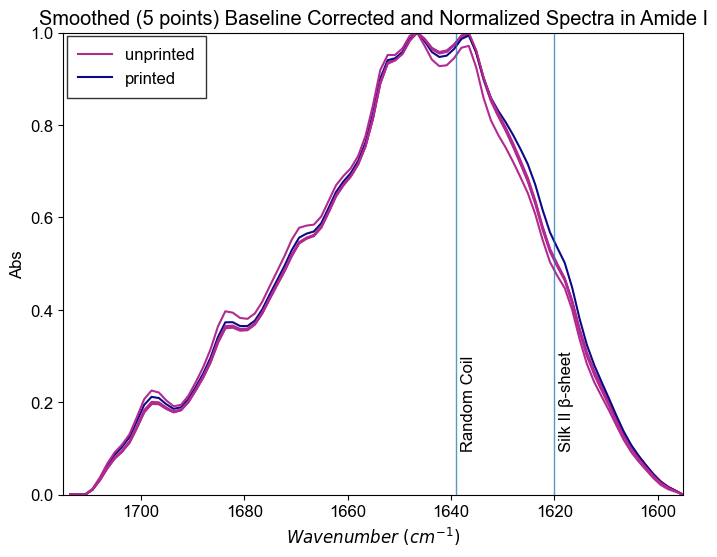

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from numpy import linspace
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = 'Arial'
plt.rcParams.update({'font.size': 12})

#Get colors from good colormap in python - using plasma?
start = 0.0
stop = 1.0
number_of_lines= 6
cm_subsection = linspace(start, stop, number_of_lines) 

# commented 4.15.2024 
## Group columns by their shared text and assign colors
# colors = {'0L': cm.plasma(cm_subsection[5]), '1L': cm.plasma(cm_subsection[4]), '2L': cm.plasma(cm_subsection[3]), '4L': cm.plasma(cm_subsection[2]),'8L': cm.plasma(cm_subsection[1]),'16L': cm.plasma(cm_subsection[0]) }

# Group columns by their shared inside vs outside of print area
colors = {'0L': cm.plasma(cm_subsection[5]), 'unprinted': cm.plasma(cm_subsection[2]),'8L': cm.plasma(cm_subsection[1]),'printed': cm.plasma(cm_subsection[0]) }


# Plotting
plt.figure(figsize=(8, 6))
handles = []
labels = set()
columncount = 0

for column in normalized_baseline_AmideIdf.columns[1:]:  # Exclude the 'wavenumber' column
    
    #added to handle different formatting from dpt on 4.9.2024 but from 3/2023
    if filenamevar[0].endswith('.dpt'): 
        
        if (column.split('_')[0] == 'unprinted'):
            prefix = 'unprinted'
        else:
            prefix = 'printed'

    color = colors.get(prefix)  # Get color for the column
    
    if prefix not in labels:
        labels.add(prefix)
        line, = plt.plot(normalized_baseline_AmideIdf['wavenumber'], normalized_baseline_AmideIdf[column], color=color, label=prefix)
        handles.append(line)
    else:
        #Commented 4.15.2024 -I think this was here to clean data from a prior experiment analyzed week of 4/8/2024
        # if filenamevar[0].endswith('.dpt'): 
        #     if (columncount<99)|(columncount>131):
        #         plt.plot(normalized_baseline_AmideIdf['wavenumber'], normalized_baseline_AmideIdf[column], color=color)
        # else:
        if (columncount<(50-15))|(columncount>(74-15)):
            
            if (columncount%4==0):
                print(columncount)
                plt.plot(normalized_baseline_AmideIdf['wavenumber'], normalized_baseline_AmideIdf[column], color=color)

        else:    
            plt.plot(normalized_baseline_AmideIdf['wavenumber'], normalized_baseline_AmideIdf[column], color=color)
        columncount+=1
plt.xlabel('$Wavenumber\ (cm^{-1})$')
plt.ylabel('Abs')
leg = plt.legend(handles=handles)
leg.get_frame().set_edgecolor('k')
leg.get_frame().set_boxstyle('Square')
plt.title('Smoothed (5 points) Baseline Corrected and Normalized Spectra in Amide I')
plt.gca().invert_xaxis()
plt.ylim(0,1.0)
plt.xlim(1715,1595)
plt.axvline(x=1639,linewidth=1, alpha = 0.75)
plt.text(1638,.1,'Random Coil',rotation=90)
plt.axvline(x=1620,linewidth=1, alpha = 0.75)
plt.text(1619,.1,'Silk II β-sheet',rotation=90)
plt.savefig(savefolderpath+'/'+'SmoothedSpectraOnTopOfEachOther'+'.svg')
plt.show()

In [22]:
from scipy.signal import savgol_filter 
smoothed_normalized_baseline_AmideIdf = pd.DataFrame(savgol_filter(normalized_baseline_AmideIdf, 5, 1, axis=0),
                                columns=normalized_baseline_AmideIdf.columns,
                                index=normalized_baseline_AmideIdf.index)
smoothed_normalized_baseline_AmideIdf

,wavenumber,unprinted_0,unprinted_1,unprinted_2,unprinted_3,unprinted_4,unprinted_5,printed_0,printed_1,printed_2,unprinted_6,unprinted_7,unprinted_8,unprinted_9,unprinted_10,unprinted_11
0,1713.649892,-0.006242,-0.006232,-0.006314,-0.006255,-0.006321,-0.006282,-0.006883,-0.007056,-0.007115,-0.007080,-0.007425,-0.006568,-0.006495,-0.006908,-0.006441
1,1712.221850,0.001060,0.001055,0.001090,0.001065,0.001069,0.001070,0.001177,0.001196,0.001207,0.001190,0.001251,0.001115,0.001106,0.001083,0.001100
2,1710.793808,0.008363,0.008341,0.008494,0.008386,0.008460,0.008423,0.009238,0.009447,0.009529,0.009460,0.009927,0.008799,0.008707,0.009073,0.008641
3,1709.365766,0.019730,0.019709,0.019912,0.019766,0.019971,0.019837,0.021739,0.022325,0.022473,0.022304,0.023354,0.020711,0.020501,0.021891,0.020328
4,1707.937724,0.035359,0.035354,0.035561,0.035410,0.035793,0.035490,0.038973,0.040069,0.040277,0.039818,0.041619,0.037020,0.036660,0.039443,0.036380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,1600.834608,0.047539,0.047033,0.046634,0.046798,0.046718,0.045471,0.047376,0.046347,0.046474,0.037327,0.038932,0.039830,0.043288,0.048021,0.043619
80,1599.406566,0.032578,0.032271,0.031936,0.031948,0.031976,0.031060,0.032176,0.031311,0.031620,0.024685,0.025798,0.026731,0.029331,0.032411,0.029586
81,1597.978524,0.019838,0.019696,0.019447,0.019386,0.019456,0.018859,0.019408,0.018757,0.019115,0.014378,0.015056,0.015897,0.017640,0.019339,0.017813
82,1596.550481,0.008873,0.008866,0.008720,0.008636,0.008729,0.008436,0.008607,0.008239,0.008521,0.006043,0.006375,0.006918,0.007779,0.008377,0.007855


printed
printed
printed


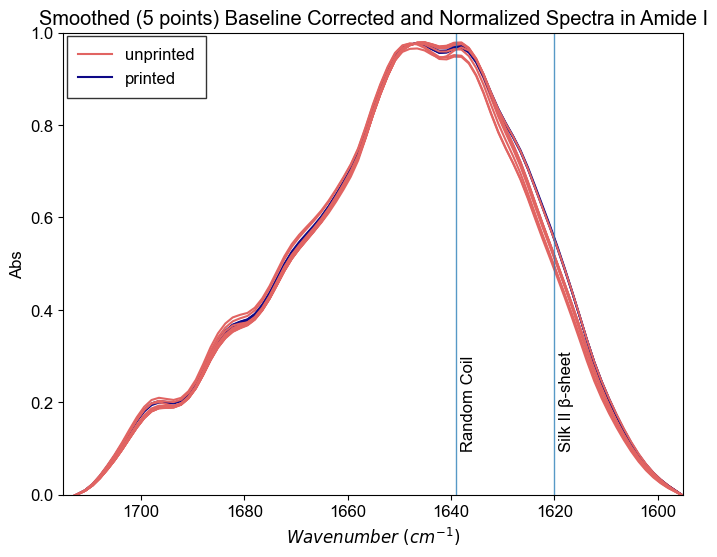

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from numpy import linspace
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = 'Arial'
plt.rcParams.update({'font.size': 12})

#Get colors from good colormap in python - using plasma?
start = 0.0
stop = 1.0
number_of_lines= 6
cm_subsection = linspace(start, stop, number_of_lines) 

# Group columns by their shared inside vs outside of print area
colors = { 'unprinted': cm.plasma(cm_subsection[3]),'printed': cm.plasma(cm_subsection[0]) }


# Plotting
plt.figure(figsize=(8, 6))
handles = []
labels = set()
columncount = 0

for column in smoothed_normalized_baseline_AmideIdf.columns[1:]:  # Exclude the 'wavenumber' column
    
    #added to handle different formatting from dpt on 4.9.2024 but from 3/2023
    if filenamevar[0].endswith('.dpt'): 
        
        if (column.split('_')[0] == 'unprinted'):
            prefix = 'unprinted'
        else:
            prefix = 'printed'
            print('printed')
    # else:
    #      prefix = column.split('.')[0] # Get the prefix before the period
        
    color = colors.get(prefix)  # Get color for the column
    
    if prefix not in labels:
        labels.add(prefix)
        line, = plt.plot(smoothed_normalized_baseline_AmideIdf['wavenumber'], smoothed_normalized_baseline_AmideIdf[column], color=color, label=prefix)
        handles.append(line)
    else:
        #Commented 4.15.2024 -I think this was here to clean data from a prior experiment analyzed week of 4/8/2024
        # if filenamevar[0].endswith('.dpt'): 
        #     if (columncount<99)|(columncount>131):
        #         plt.plot(normalized_baseline_AmideIdf['wavenumber'], normalized_baseline_AmideIdf[column], color=color)
  
        plt.plot(smoothed_normalized_baseline_AmideIdf['wavenumber'], smoothed_normalized_baseline_AmideIdf[column], color=color)

        columncount+=1
plt.xlabel('$Wavenumber\ (cm^{-1})$')
plt.ylabel('Abs')
leg = plt.legend(handles=handles)
leg.get_frame().set_edgecolor('k')
leg.get_frame().set_boxstyle('Square')
plt.title('Smoothed (5 points) Baseline Corrected and Normalized Spectra in Amide I')
plt.gca().invert_xaxis()
plt.ylim(0,1.0)
plt.xlim(1715,1595)
plt.axvline(x=1639,linewidth=1, alpha = 0.75)
plt.text(1638,.1,'Random Coil',rotation=90)
plt.axvline(x=1620,linewidth=1, alpha = 0.75)
plt.text(1619,.1,'Silk II β-sheet',rotation=90)
plt.savefig(savefolderpath+'/'+'SmoothedSpectraOnTopOfEachOther'+'.svg')
plt.show()

In [34]:
normalized_baseline_AmideIdf

,wavenumber,16L_1nozzle_HR_0,16L_1nozzle_HR_1,16L_1nozzle_HR_2,16L_1nozzle_HR_3,16L_1nozzle_HR_4,16L_1nozzle_HR_5,16L_1nozzle_HR_6,16L_1nozzle_HR_7,16L_1nozzle_HR_8,...,16L_1nozzle_HR_90,16L_1nozzle_HR_91,16L_1nozzle_HR_92,16L_1nozzle_HR_93,16L_1nozzle_HR_94,16L_1nozzle_HR_95,16L_1nozzle_HR_96,16L_1nozzle_HR_97,16L_1nozzle_HR_98,16L_1nozzle_HR_99
0,1713.64989,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1712.22185,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,1710.79381,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000123,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,1709.36577,0.011002,0.011870,0.011148,0.010977,0.011244,0.011382,0.012188,0.012102,0.011834,...,0.013700,0.014068,0.013781,0.014861,0.013311,0.013509,0.014583,0.013243,0.013133,0.013059
4,1707.93772,0.032205,0.034283,0.032541,0.032389,0.033039,0.033467,0.034697,0.034872,0.034323,...,0.041020,0.041326,0.041258,0.044625,0.039538,0.040204,0.043081,0.039488,0.039166,0.038775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,1600.83461,0.040854,0.042317,0.043578,0.044066,0.044157,0.046269,0.043149,0.044448,0.044629,...,0.029132,0.030621,0.033459,0.031812,0.033525,0.033802,0.028491,0.035924,0.033618,0.036456
80,1599.40657,0.025555,0.026474,0.027693,0.027856,0.027795,0.029531,0.027194,0.028207,0.028263,...,0.015694,0.016791,0.018899,0.017170,0.019200,0.019280,0.015068,0.021018,0.019302,0.021473
81,1597.97852,0.014967,0.015473,0.016479,0.016486,0.016361,0.017595,0.016016,0.016732,0.016690,...,0.008045,0.008765,0.010068,0.008775,0.010415,0.010357,0.007599,0.011635,0.010469,0.011945
82,1596.55048,0.007686,0.007943,0.008473,0.008479,0.008402,0.009049,0.008207,0.008603,0.008533,...,0.004516,0.004827,0.005475,0.004971,0.005619,0.005569,0.004353,0.006228,0.005624,0.006310


Plot some Amide I and II

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Example DataFrame (assuming you have this DataFrame defined)
# normalized_baseline_AmideIdf = ...

# Group columns by their shared text and assign colors
colors = {'CoffeeRing_In Center': 'blue', 'CoffeeRing_in ring': 'red', 'LeftEdgeOfFilm_FLEXcon20um': 'purple', 'MiddleofFilm_FLEXcon20um': 'green'}

# Plotting
plt.figure(figsize=(12, 6))
handles = []
labels = set()
for column in normalized_baseline_AmideIandIIdf.columns[1:]:  # Exclude the 'wavenumber' column
    prefix = column.split('.')[0]  # Get the prefix before the period
    color = colors.get(prefix)  # Get color for the column
    
    if prefix not in labels:
        labels.add(prefix)
        line, = plt.plot(normalized_baseline_AmideIandIIdf['wavenumber'], normalized_baseline_AmideIandIIdf[column], color=color, label=prefix, linewidth = .5)
        handles.append(line)
    else:
        plt.plot(normalized_baseline_AmideIandIIdf['wavenumber'], normalized_baseline_AmideIandIIdf[column], color=color,linewidth = .5)

plt.xlabel('Wavenumber')
plt.ylabel('Abs')
plt.legend(handles=handles)
plt.title('Coffee Ring vs Knife-Coated R2R Film Edge, Amide I and II')
plt.gca().invert_xaxis()
plt.ylim(0,1.05)
plt.xlim(1715,1475)
#AmideI
plt.axvline(x=1651,linewidth=1, alpha = 0.75)
plt.text(1650,.1,'Silk I β-turn',rotation=90)
plt.axvline(x=1639,linewidth=1, alpha = 0.75)
plt.text(1638,.1,'Random Coil',rotation=90)
plt.axvline(x=1620,linewidth=1, alpha = 0.75)
plt.text(1619,.1,'Silk II β-sheet',rotation=90)
#AmideII
plt.axvline(x=1515,linewidth=1, alpha = 0.75)
plt.text(1514,.1,'Silk II β-Sheet',rotation=90)
plt.axvline(x=1539,linewidth=1, alpha = 0.75)
plt.text(1538,.1,'Silk I β-turn',rotation=90)

plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Example DataFrame (assuming you have this DataFrame defined)
# normalized_baseline_AmideIdf = ...

# Desired text before the dot and number at the end of the header names
desired_text = [ 'CoffeeRing_In Center', 'CoffeeRing_in ring']

# Group columns by their shared text and assign colors
colors = {'CoffeeRing_In Center': 'blue', 'CoffeeRing_in ring': 'red', 'LeftEdgeOfFilm_FLEXcon20um': 'purple', 'MiddleofFilm_FLEXcon20um': 'green'}

# Plotting
plt.figure(figsize=(14, 6))
handles = []
labels = set()
for column in normalized_baseline_AmideIandIIdf.columns[1:]:  # Exclude the 'wavenumber' column
    prefix = column.rsplit('.')[0]  # Extract text before the dot and number
    if prefix in desired_text:  # Check if the extracted prefix is in the desired text
        color = colors.get(prefix)  # Get color for the column
        
        if prefix not in labels:
            labels.add(prefix)
            line, = plt.plot(normalized_baseline_AmideIandIIdf['wavenumber'], normalized_baseline_AmideIandIIdf[column], color=color, label=prefix, linewidth=0.5)
            handles.append(line)
        else:
            plt.plot(normalized_baseline_AmideIandIIdf['wavenumber'], normalized_baseline_AmideIandIIdf[column], color=color, linewidth=0.5)

# Code to change the legend text for 'CoffeeRing_in ring' to 'CoffeeRing_On Edge'
handles, labels = plt.gca().get_legend_handles_labels()

for i, label in enumerate(labels):
    if label == 'CoffeeRing_in ring':
        labels[i] = 'Edge of Film'
    if label == 'CoffeeRing_In Center':
        labels[i] = 'Center of Film'

plt.xlabel('Wavenumber ($cm^{-1}$)',fontsize = 14)
plt.ylabel('Abs', fontsize = 14)
plt.legend(handles, labels,loc='upper right')
plt.title('Dropcast coffee ring: Edge vs Center, (Amide I and II)', fontsize = 16)
plt.gca().invert_xaxis()
plt.ylim(0, 1.05)
plt.xlim(1715, 1475)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#AmideI
plt.axvline(x=1651,linewidth=1, alpha = 0.75)
plt.text(1650,.1,'Silk I β-turn',rotation=90)
plt.axvline(x=1639,linewidth=1, alpha = 0.75)
plt.text(1638,.1,'Random Coil',rotation=90)
plt.axvline(x=1620,linewidth=1, alpha = 0.75)
plt.text(1619,.1,'Silk II β-sheet',rotation=90)
#AmideII
plt.axvline(x=1515,linewidth=1, alpha = 0.75)
plt.text(1514,.1,'Silk II β-Sheet',rotation=90)
plt.axvline(x=1539,linewidth=1, alpha = 0.75)
plt.text(1538,.1,'Silk I β-turn',rotation=90)

plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Example DataFrame (assuming you have this DataFrame defined)
# normalized_baseline_AmideIdf = ...

# Desired text before the dot and number at the end of the header names
desired_text = [ 'LeftEdgeOfFilm_FLEXcon20um', 'MiddleofFilm_FLEXcon20um']

# Group columns by their shared text and assign colors
colors = {'LeftEdgeOfFilm_FLEXcon20um': 'red', 'MiddleofFilm_FLEXcon20um': 'blue'}

# pattern = re.compile(r'Left([^_]+)')

# Plotting
plt.figure(figsize=(14, 6))
handles = []
labels = set()
for column in normalized_baseline_AmideIandIIdf.columns[1:]:  # Exclude the 'wavenumber' column
    prefix = column.rsplit('.')[0]  # Extract text before the dot and number
    if prefix in desired_text:  # Check if the extracted prefix is in the desired text
        color = colors.get(prefix)  # Get color for the column
        
        if prefix not in labels:
            labels.add(prefix)
            line, = plt.plot(normalized_baseline_AmideIandIIdf['wavenumber'], normalized_baseline_AmideIandIIdf[column], color=color, label=prefix, linewidth=0.5)
            handles.append(line)
            print(line)
        else:
            plt.plot(normalized_baseline_AmideIandIIdf['wavenumber'], normalized_baseline_AmideIandIIdf[column], color=color, linewidth=0.5)


# for handle in handles:
#     handle.set_label(handle.get_label().split('Left')[1])  # Get only the text before the dot and number
            
# Code to change the legend text for 'CoffeeRing_in ring' to 'CoffeeRing_On Edge'
handles, labels = plt.gca().get_legend_handles_labels()

for i, label in enumerate(labels):
    if label == 'LeftEdgeOfFilm_FLEXcon20um':
        labels[i] = 'Edge of Film'
    if label == 'MiddleofFilm_FLEXcon20um':
        labels[i] = 'Center of Film'

handles = handles[::-1]
labels = labels[::-1]



plt.xlabel('Wavenumber ($cm^{-1}$)',fontsize = 14)
plt.ylabel('Abs',fontsize = 14)
plt.legend(handles, labels,loc='upper right')

plt.title('Knife-Coated Sheet Film: Edge vs Center, (Amide I and II)',fontsize = 16)
plt.gca().invert_xaxis()
plt.ylim(0, 1.05)
plt.xlim(1715, 1475)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#AmideI
plt.axvline(x=1651,linewidth=1, alpha = 0.75)
plt.text(1650,.1,'Silk I β-turn',rotation=90)
plt.axvline(x=1639,linewidth=1, alpha = 0.75)
plt.text(1638,.1,'Random Coil',rotation=90)
plt.axvline(x=1620,linewidth=1, alpha = 0.75)
plt.text(1619,.1,'Silk II β-sheet',rotation=90)
#AmideII
plt.axvline(x=1515,linewidth=1, alpha = 0.75)
plt.text(1514,.1,'Silk II β-Sheet',rotation=90)
plt.axvline(x=1539,linewidth=1, alpha = 0.75)
plt.text(1538,.1,'Silk I β-turn',rotation=90)

plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re

# Example DataFrame (assuming you have this DataFrame defined)
# normalized_baseline_AmideIdf = ...

# Desired text before the dot and number at the end of the header names
desired_text = ['LeftEdgeOfFilm', 'MiddleofFilm']

# Group columns by their shared text and assign colors
colors = {'CoffeeRing': 'blue', 'LeftEdgeOfFilm': 'red', 'MiddleofFilm': 'green'}

# Plotting
plt.figure(figsize=(12, 6))
handles = []
labels = set()
for column in normalized_baseline_AmideIandIIdf.columns[1:]:  # Exclude the 'wavenumber' column
    prefix = column.rsplit('_', 1)[0]  # Extract text before the dot and number
    if prefix in desired_text:  # Check if the extracted prefix is in the desired text
        color = colors.get(prefix)  # Get color for the column
        
        if prefix not in labels:
            labels.add(prefix)
            line, = plt.plot(normalized_baseline_AmideIandIIdf['wavenumber'], normalized_baseline_AmideIandIIdf[column], color=color, label=column, linewidth=0.5)
            handles.append(line)
        else:
            plt.plot(normalized_baseline_AmideIandIIdf['wavenumber'], normalized_baseline_AmideIandIIdf[column], color=color, linewidth=0.5)

# Adjust labels in the legend
for handle in handles:
    original_label = handle.get_label()
    match_left = re.search(r'Left(.+)', original_label)  # Match text after 'Left'
    match_dot = re.search(r'([^_]+)\.\d+', original_label)  # Match text before dot and number
    if match_left and match_dot:
        new_label = f"{match_left.group(1)} - {match_dot.group(1)}"
        handle.set_label(new_label)

plt.xlabel('Wavenumber')
plt.ylabel('Abs')
plt.legend(handles=handles)
plt.title('Coffee Ring vs Knife-Coated R2R Film Edge, Amide I and II')
plt.gca().invert_xaxis()
plt.ylim(0, 1.05)
plt.xlim(1715, 1475)
plt.show()


In [ ]:
header_name1 = {'LeftEdgeOfFilm_FLEXcon20um','MiddleOfFilm_FLEXcon20um'}
header_name2

columns_with_header1 = [col for col in normalized_baseline_AmideIandII_wLocRowdf.columns if col == header_name]
columns_with_header1 = [col for col in normalized_baseline_AmideIandII_wLocRowdf.columns if col == header_name]

# Check if there are columns with the specified header
if columns_with_header:
    # Select the first column with the specified header (assuming unique plotting)
    selected_column = columns_with_header[0]
    
    # Plot the values from the selected column
    plt.plot(normalized_baseline_AmideIandII_wLocRowdf.index, normalized_baseline_AmideIandII_wLocRowdf[selected_column], label=selected_column)
    plt.xlabel('Index')
    plt.ylabel('Values')
    plt.title(f'Plot of {selected_column}')
    plt.legend()
    plt.show()
else:
    print(f"No columns found with the header name '{header_name}'")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Example DataFrame (assuming you have this DataFrame defined)
# normalized_baseline_AmideIdf = ...

# Group columns by their shared text and assign colors
colors = {'LeftEdgeOfFilm_FLEXcon20um': 'purple', 'MiddleofFilm_FLEXcon20um': 'green'}
order = ['LeftEdgeOfFilm_FLEXcon20um','MiddleofFilm_FLEXcon20um']

# Plotting
plt.figure(figsize=(12, 6))
handles = []
labels = set()
for column in normalized_baseline_AmideIandII_wLocRowdf.columns[1:]:  # Exclude the 'wavenumber' column
    if column in order:
            prefix = column # Get the prefix before the period
            print(prefix)
            color = colors.get(prefix)  # Get color for the column
            print(color)
        
            if prefix not in labels:
                labels.add(prefix)
                print(normalized_baseline_AmideIandII_wLocRowdf[column])
                line, = plt.plot(normalized_baseline_AmideIandII_wLocRowdf['wavenumber'], normalized_baseline_AmideIandII_wLocRowdf[column], color=color, label=prefix, linewidth = .5)
                handles.append(line)
            else:
                plt.plot(normalized_baseline_AmideIandII_wLocRowdf['wavenumber'], normalized_baseline_AmideIandII_wLocRowdf[column], color=color,linewidth = .5)

plt.xlabel('Wavenumber')
plt.ylabel('Abs')
plt.legend(handles=handles)
plt.title('Coffee Ring vs Knife-Coated R2R Film Edge, Amide I and II')
plt.gca().invert_xaxis()
plt.ylim(0,1.05)
plt.xlim(1715,1475)
plt.show()

## Peak settings for peak fitting

In [38]:
#  Commented on 4.6.2024 
# four_peak = {
#     #Good for sharp distinction when there are strong beta sheet peaks:
#     'means': [1625,  1637, 1679, 1700],
#     'uncertainties': [(1613, 1626), (1632, 1642), (1668, 1685), (1697, 1703)],
  
#     #  #what I've been using for many normal analysis
#     # 'means': [1627,  1650, 1679,1700],
#     # 'uncertainties': [(1613, 1632), (1640, 1657), (1668, 1685), (1697, 1703)],
    
#     # 'relative_uncertainties': [10, 12, 16,3],
#     # 'relative_uncertainties': [2, 2, 1,2],
#     'assignments': ['aggregate \u03B2-strand/\u03B2-sheet',
#                     'random coils + \u03B1 helices', '\u03B2-turns', 'intermolecular \u03B2-sheets (weak)']}

#  Commented above on 4.6.2024 and pulled peaks from 2023 11-03-2023_IPAcomparison
four_peak = {
    'means': [1620,  1636, 1679, 1700],
    # 'means': [1627,  1650, 1679,1700],

    'uncertainties': [(1613, 1626), (1627, 1664), (1668, 1685), (1697, 1703)],
    # 'uncertainties': [(1613, 1632), (1640, 1657), (1668, 1685), (1697, 1703)],
    # 'relative_uncertainties': [10, 12, 16,3],
    # 'relative_uncertainties': [2, 2, 1,2],
    'assignments': ['aggregate \u03B2-strand/\u03B2-sheet',
                    'random coils + \u03B1 helices', '\u03B2-turns', 'intermolecular \u03B2-sheets (weak)']}

###Plotting spectra and their invidual fits

In [15]:
# Jeff 8/25/2022: attempt to redo this portion more simply. Import it as is, and if the file is an image from the microscope (multiple spectra in one file), then flip it
from matplotlib.offsetbox import AnchoredText
from ftir.modeling.peak_definitions import four_peak_2024_MeOH
from datetime import date

plt.ioff()
#reluncert = 5

#  Approach: make a grid as it is pulled from non-flattened indices so that I can more easily think about the math for propper placement of "pixels";  subplots in python normally start at top left, but
# should actually start at bottom left for opus ftir microscope files. Possibly put another gui to allow users to select which corner data collection starts in/ ]
# ultimate goal is to directly extract data with (x,y) pixel location from opus files and avoid this issue completely

pw = 30  # peak width 30cm^-1 from "Quantitative approach to study secondary structure of proteins by FT-IR spectroscopy, using a model wheat gluten system"
gainnum = .95  # gain; was originally 0.95

# #Commented on 4.7.2024 to test out peak imports
# peakfitlibname = 'four_peak'
# peaksfittinglib = four_peak
peaksfitlibname = 'four_peak_2024_MeOH'
peaksfittinglib = four_peak_2024_MeOH

rearranged_CB_color_cycle = ['#377eb8', '#4daf4a', '#ff7f00',  '#377eb8'] # RC/helix, beta turn, then beta sheet

fig, axs = plt.subplots(num_in_y, num_in_x, figsize=(num_in_x*8.5, num_in_y*5), dpi=200)
# if (num_in_x<15) and (num_in_y<15):
#     print('high res')
#     fig, axs = plt.subplots(num_in_y, num_in_x, figsize=(num_in_x*8.5, num_in_y*5), dpi=200)
# else:
#     print('low res')
#     fig, axs = plt.subplots(num_in_y, num_in_x, figsize=(num_in_x*1.2, num_in_y*1), dpi=50)

titletext = ('Date Processed: ' + str(date.today()) + '\n'+
    'Peak Fitting Parameters' + '\n' + 'Peak Means:' + str(peaksfittinglib['means']) + "\n" + 'Uncertainties: ' + str(peaksfittinglib['uncertainties']) +
             "\n" + 'Starting Peak Intensity (gain): ' + str(gainnum) + ', Peak Width: ' + str(pw))
fig.suptitle(titletext, fontsize=18, y=1.05, va='top')
fig.subplots_adjust(hspace=.3, wspace=.3)
plt.figure(facecolor='white')
fig.patch.set_facecolor('white')

structs = []
gaussian_data = []
secondary_structs_df = pd.DataFrame()
dashlist = ['--', '--', '--', '-.']

# if grid_layout == True: 
for j in range(0, num_in_y):
    for i in range(0, num_in_x):
        #August 31 2023: added if statement to discern between multiple file uploads vs one file with multiple datapoints as I think the ordermight be getting messed up here
        if (len(filenamevar) > 1)|(imagecheck =='False'):
            indexnum = i+j*(num_in_x)
        else:
            indexnum = (num_in_x)*(num_in_y-(j+1))+i # this should convert current index to the correct index from the original "linear" dataset for plotting purposes since the data point table doesn't have any location information
        sample = baseline_corrected_AmideI[indexnum].columns[1] #actual data from sample (not the wavenumber)
        area, res = gaussian_least_squares(baseline_corrected_AmideI[indexnum], sample, peak_width=pw,peaks=peaksfittinglib, params={'loss': 'linear'})
        structs.append(secondary_structure(area, peaksfittinglib)) # secondary_structure() returns dict-> ### At some point, I should make this into a single dataframe###
        gaussian_list_data = gaussian_list(baseline_corrected_AmideI[indexnum]['wavenumber'], *res.x)
        gaussian_data.append(gaussian_list_data)
        secondary_structs_df.append(pd.DataFrame.from_dict(structs, orient='columns'))
        xdata = baseline_corrected_AmideI[indexnum].iloc[:, 0]
        y_fit = sum(gaussian_list_data)
        # probably should have just done this normally and then transposed/flipped the data frame. Maybe next time
        # index is a bit whack here, need to start from bottom left and starts from top left
        # need to modify for running a series of data not from mapping, or running a line (in which case one of the two dimensions are ==1)
        if (num_in_y == 1) or (num_in_x == 1):
            # need to modify this still to work if it's a y-direction sinle line (just need to change index somehow with j and i maybe?)
            # Jeff changed this to 'Baseline Corrected' from '$2^{nd}$ derivative' on 3.23.2022
            axs[i].plot(xdata, baseline_corrected_AmideI[i]
                        [sample], label='Baseline Corrected')
            axs[i].plot(xdata, y_fit, label='Model fit', ls='-.', linewidth=1)
            
            # calculate RSS for each spectrum - want to minimize this, might need to run some algorithm to do this 
            resid = baseline_corrected_AmideI[indexnum][sample] - y_fit
            rss = sum(resid*resid)

        # Label each of the gaussian curves with the correct type of peak
            for k in range(0, len(gaussian_list_data)):
                axs[i].plot(xdata, gaussian_list_data[len(peaksfittinglib['means'])-1-k], ls=dashlist[k],
                            label=str(peaksfittinglib['assignments'][len(peaksfittinglib['means'])-1-k]), alpha=0.6, color=rearranged_CB_color_cycle[k])  # label=str(structs[j][1])) #label='')
            axs[i].invert_xaxis()

            legend1 = axs[i].legend(
                loc="upper left", fontsize='small', frameon=True)
            legend1.get_frame().set_edgecolor('b')
            rssTitle = "RSS: " + str("{:.1e}".format(rss))
            rssText = AnchoredText(rssTitle, loc='upper right', prop=dict(
                size=8), frameon=True, bbox_to_anchor=(1., 0.8), bbox_transform=axs[i].transAxes)
            ratioText = ('\u03B2-Sheet:' + str("{:.0%}".format(structs[num_in_x*j+i]['aggregate \u03B2-strand/\u03B2-sheet'] +
                structs[num_in_x*j+i]['intermolecular \u03B2-sheets (weak)'])) + '\n' + '\u03B1-Helix/' + '\n' + 'Random Coil:' 
                + str("{:.0%}".format(structs[num_in_x*j+i]['random coils + \u03B1 helices'])) +
                '\n'+'\u03B2-turns:' + str("{:.0%}".format(structs[num_in_x*j+i]['\u03B2-turns'])))
            axs[i].add_artist(rssText)
            aRatioText = AnchoredText(
                ratioText, loc='upper right', prop=dict(size=8), frameon=True)
            axs[i].add_artist(aRatioText)
            
            strindexnum = str(sample) #strindexnum= str(indexnum), can also use #strindexnum = strindexnum.split('.')[0], depends on how you want to split
            
            plt.setp(axs[:], ylabel='Arbitrary Absorbance Units')
            plt.setp(axs[:], xlabel=r'$Wavenumber (cm^{-1})$')

            #numberinlist = AnchoredText(strindexnum, loc='upper center', prop=dict(size=7),frameon=False)
            # axs[i].add_artist(numberinlist)
            axs[i].set_title(strindexnum)
        else:
            axs[j, i].plot(xdata, baseline_corrected_AmideI[indexnum][sample],
                        label='Baseline Corrected', color='black', linewidth=0.75) # Jeff changed this to 'Baseline Corrected' from '$2^{nd}$ derivative' on 3.23.2022
            axs[j, i].plot(xdata, y_fit, label='Model fit',ls='--', linewidth=1, color='grey')
            # calculate RSS for each spectrum, want to minimize this, might need to run some algorithm to do this
            resid = baseline_corrected_AmideI[indexnum][sample] - y_fit
            rss = sum(resid*resid) 
            #Label each of the gaussian curves with the correct type of peak
            for k in range(len(gaussian_list_data)):
                axs[j, i].plot(xdata, gaussian_list_data[len(peaksfittinglib['means'])-1-k], ls=dashlist[k],  # ls='--',
                            label=str(peaksfittinglib['assignments'][len(peaksfittinglib['means'])-1-k]), color=rearranged_CB_color_cycle[k])  # label=str(structs[j][1])) #label='')
                axs[j, i].fill_between(xdata, gaussian_list_data[len(
                    peaksfittinglib['means'])-1-k], alpha=0.6, color=rearranged_CB_color_cycle[k])
            axs[j, i].invert_xaxis()

            legend1 = axs[j, i].legend(loc="upper left", fontsize='xx-small')
            legend1.get_frame().set_edgecolor('k')
            ratioText = ('\u03B2-Sheet:' + str("{:.0%}".format(structs[num_in_x*j+i]['aggregate \u03B2-strand/\u03B2-sheet'] +
                                                            structs[num_in_x*j+i]['intermolecular \u03B2-sheets (weak)'])) + '\n' + '\u03B1-Helix/'+'\n' + 'Random Coil:' + str("{:.0%}".format(structs[num_in_x*j+i]['random coils + \u03B1 helices'])) +
                        '\n'+'\u03B2-turns:' + str("{:.0%}".format(structs[num_in_x*j+i]['\u03B2-turns'])) + '\n' + 'RSS:' + str("{:.1e}".format(rss)))
            aRatioText = AnchoredText(
                ratioText, loc='upper right', prop=dict(size=6), frameon=False)
            axs[j, i].add_artist(aRatioText)
            strindexnum = str(sample) #strindexnum= str(indexnum)
            numberinlist = AnchoredText(
                strindexnum, loc='upper right', prop=dict(size=6), frameon=False)
            plt.setp(axs[:], ylabel='Arbitrary Absorbance Units')
            plt.setp(axs[:], xlabel=r'$Wavenumber (cm^{-1})$')
            # axs[j,i].add_artist(numberinlist)
            axs[j, i].set_title(strindexnum)
plt.gcf()
# fullfigname = (savefolderpath+'/'+'spectra.png')
# fig.savefig(fullfigname, dpi=300)
fullfignamesvg = (savefolderpath+'/'+'spectra.svg')
fig.savefig(fullfignamesvg, format="svg")
plt.close(fig)

#Compare % of beta sheet via Seaborn Heatmap#

In [16]:
total_beta_percent = []
for i in range(0, len(structs)):
    total_beta_percent.append(
        structs[i]['aggregate \u03B2-strand/\u03B2-sheet'] + structs[i]['intermolecular \u03B2-sheets (weak)'])
# also make a new dataframe for math later
#total_beta_percent_df = pd.DataFrame(columns = total_beta_percent)

#print('total beta %', total_beta_percent)

# make two DFs, one with all secondary structure values, and then another one with total beta sheet only
secondary_structs_df = pd.DataFrame.from_dict(structs, orient='columns')  # columns=rawData_df[2:].columns)
secondary_structs_df = secondary_structs_df.transpose()
secondary_structs_df.columns = rawData_df.columns[1:]


total_beta_sheet_df = pd.DataFrame(
    total_beta_percent, columns=['TotalBetaSheet%'])
#total_beta_sheet_df.index = rawData_df.columns[0:]
#rawData_df.columns[0] = rawData_df.columns['fileheader','total beta_sheet %']

# extractedtime = []
# extractedsamplenumber = []
# for i in range(len(rawData_df.columns[1:])):
#     splitname = rawData_df.columns[1:][i].split("min")
#     extractedtime.append(int(splitname[0]))
#     splitname2 = rawData_df.columns[1:][i].split(".")
#     extractedsamplenumber.append(splitname2[1])
# print(extractedtime)

# total_beta_sheet_df['Minutes'] = extractedtime
# total_beta_sheet_df['SampleNumber'] = extractedsamplenumber
# total_beta_sheet_df = total_beta_sheet_df[['Minutes','SampleNumber','TotalBetaSheet%']]


# print(total_beta_sheet_df)
# #print(total_beta_sheet_df['1hr.0'])
# #print(total_beta_sheet_df['1hr.0']+total_beta_sheet_df['1hr.1'])

# #total_beta_sheet_df[total_beta_sheet_df['Minutes']==5]['TotalBetaSheet%']
# total_beta_sheet_df['TotalBetaSheet%'].plot()

In [17]:
pd.DataFrame.from_dict(structs, orient='columns').T

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
aggregate β-strand/β-sheet,0.060401,0.048515,0.066882,0.060851,0.069620,0.049512,0.055133,0.057469,0.053822,0.061095,...,0.079880,0.073815,0.076378,0.077632,0.077946,0.075945,0.072787,0.077641,0.077401,0.077391
β-turns,0.271298,0.282153,0.261377,0.281406,0.256094,0.281542,0.273619,0.275284,0.283431,0.268219,...,0.249112,0.257859,0.255106,0.253479,0.251219,0.248328,0.257318,0.248648,0.249181,0.250090
random coils + α helices,0.656277,0.656452,0.659238,0.657726,0.661815,0.656933,0.658763,0.654833,0.649372,0.658558,...,0.660591,0.657958,0.657899,0.658317,0.660076,0.665627,0.659623,0.663727,0.663439,0.662361
intermolecular β-sheets (weak),0.012024,0.012880,0.012503,0.000017,0.012471,0.012013,0.012485,0.012414,0.013376,0.012128,...,0.010417,0.010368,0.010618,0.010571,0.010759,0.010101,0.010272,0.009984,0.009979,0.010159


In [18]:
# labeled_secondary_structs_df = secondary_structs_df
# labeled_secondary_structs_df.columns = 27*["layers_16"]+ 27*["layers_8"]+27*["layers_4"]+ 27*["layers_2"]+36*["layers_1"]+(len(secondary_structs_df.columns)-(27*4+36))*["control"]

# class renamer():
#     def __init__(self):
#         self.d = dict()

#     def __call__(self, x):
#         if x not in self.d:
#             self.d[x] = 0
#             if x == "wavenumber":
#                 return x
#             else:
#                 return "%s_%d" % (x, self.d[x])
#         else:
#             self.d[x] += 1
#             return "%s_%d" % (x, self.d[x])

# labeled_secondary_structs_df.rename(columns=renamer(), inplace=True)

# labeled_secondary_structs_df  

In [19]:
secondary_structs_df

,16L_1nozzle_HR,16L_1nozzle_HR,16L_1nozzle_HR,16L_1nozzle_HR,16L_1nozzle_HR,16L_1nozzle_HR,16L_1nozzle_HR,16L_1nozzle_HR,16L_1nozzle_HR,16L_1nozzle_HR,...,16L_1nozzle_HR,16L_1nozzle_HR,16L_1nozzle_HR,16L_1nozzle_HR,16L_1nozzle_HR,16L_1nozzle_HR,16L_1nozzle_HR,16L_1nozzle_HR,16L_1nozzle_HR,16L_1nozzle_HR
aggregate β-strand/β-sheet,0.060401,0.048515,0.066882,0.060851,0.069620,0.049512,0.055133,0.057469,0.053822,0.061095,...,0.079880,0.073815,0.076378,0.077632,0.077946,0.075945,0.072787,0.077641,0.077401,0.077391
β-turns,0.271298,0.282153,0.261377,0.281406,0.256094,0.281542,0.273619,0.275284,0.283431,0.268219,...,0.249112,0.257859,0.255106,0.253479,0.251219,0.248328,0.257318,0.248648,0.249181,0.250090
random coils + α helices,0.656277,0.656452,0.659238,0.657726,0.661815,0.656933,0.658763,0.654833,0.649372,0.658558,...,0.660591,0.657958,0.657899,0.658317,0.660076,0.665627,0.659623,0.663727,0.663439,0.662361
intermolecular β-sheets (weak),0.012024,0.012880,0.012503,0.000017,0.012471,0.012013,0.012485,0.012414,0.013376,0.012128,...,0.010417,0.010368,0.010618,0.010571,0.010759,0.010101,0.010272,0.009984,0.009979,0.010159


In [20]:
shortenedhead_secondary_structs_df = secondary_structs_df

# headers = shortenedhead_secondary_structs_df.columns
# headers = headers.str.replace('_.*', '')

# # Set the new column names
# shortenedhead_secondary_structs_df.columns = headers

In [21]:
totalbetasavename = (savefolderpath+'/'+'1D_Total_beta_sheet.csv')
total_beta_sheet_df.to_csv(totalbetasavename, index=False)
#total_beta_sheet_df.to_csv("1D_Total_beta_sheet.csv", index = False)
total_beta_sheet_df

secondary_struct_savename = (savefolderpath+'/'+'labeled_secondary_structure.csv')
shortenedhead_secondary_structs_df.to_csv(secondary_struct_savename, index=True)

In [22]:
# Split up points into x by y grid
break_total_beta_percent = np.array_split(np.array(total_beta_percent), num_in_y)
break_total_beta_percent

[array([0.07242471, 0.06139538, 0.07938495, 0.06086748, 0.0820909 ]),
 array([0.06152468, 0.0676185 , 0.06988258, 0.06719742, 0.0732233 ]),
 array([0.06665248, 0.06445809, 0.06353895, 0.06345727, 0.06596053]),
 array([0.06516918, 0.06087137, 0.06391122, 0.06829761, 0.06644238]),
 array([0.06025589, 0.05518872, 0.0535357 , 0.04640743, 0.04669467]),
 array([0.06336561, 0.0569881 , 0.05719894, 0.05994607, 0.06283777]),
 array([0.07501949, 0.06264578, 0.06013653, 0.06235537, 0.06656671]),
 array([0.08077232, 0.06644719, 0.07429221, 0.07525267, 0.07833664]),
 array([0.07606761, 0.07812   , 0.08590323, 0.07573807, 0.08261619]),
 array([0.07374304, 0.07188178, 0.08489093, 0.05628716, 0.07836406]),
 array([0.0775183 , 0.07000322, 0.06344057, 0.07523385, 0.07122453]),
 array([0.06397663, 0.06555092, 0.07846503, 0.06383625, 0.07893657]),
 array([0.08056054, 0.06735603, 0.07892561, 0.07572555, 0.07541772]),
 array([0.08487279, 0.0772278 , 0.08382455, 0.08580902, 0.08244094]),
 array([0.08738611, 

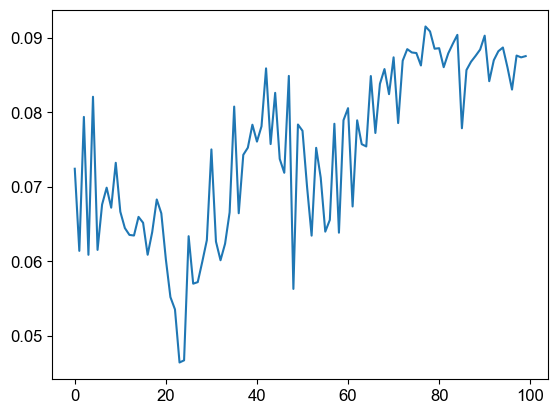

In [23]:
# 2D plot just in case it's useful
plt.plot(total_beta_percent)
fullfigname = (savefolderpath+'/'+'1-D.png')
plt.savefig(fullfigname)
plt.show()

#Labeling for easier Stats!!!!!!!!!

In [22]:
# Cut header into labels for each that can be easily accessible
cleaned_secondarystructs_df = shortenedhead_secondary_structs_df

#Add combined 'aggregate β-strand/β-sheet' and 'intermolecular β-sheet' row
cleaned_secondarystructs_df.loc['Total β-sheet content'] = cleaned_secondarystructs_df.loc['aggregate β-strand/β-sheet'] + cleaned_secondarystructs_df.loc['intermolecular β-sheets (weak)'] 

#Add row with # Layers

# cleaned_secondarystructs_df.loc['Layers'] = cleaned_secondarystructs_df.columns.str.split('.').str[0]#
cleaned_secondarystructs_df.loc['Layers'] = cleaned_secondarystructs_df.columns.astype(str)
cleaned_secondarystructs_df.loc['Layers'] = cleaned_secondarystructs_df.loc['Layers'].str.split('.').str[0]

string_to_replace = 'Control'
replacement_string = '0L'
# cleaned_secondarystructs_df.loc['Layers'] = cleaned_secondarystructs_df.loc['Layers'].str.contains(string_to_replace) = replacement_string

# cleaned_secondarystructs_df.loc[cleaned_secondarystructs_df.loc['Layers'].str.contains(string_to_replace), 'Layers'] = replacement_string

cleaned_secondarystructs_df.loc['Layers'] = cleaned_secondarystructs_df.loc['Layers'].apply(lambda x: '0' if 'ontrol' in x else x)

# cleaned_secondarystructs_df.loc['Layers'] = cleaned_secondarystructs_df.loc['Layers'].str.split('s').str[0]
# if cleaned_secondarystructs_df.loc['Alcohol'].empty():
#      domain = splitaddr[1]
# else:
#     domain = ''
cleaned_secondarystructs_df

cleaned_secondary_struct_savename = (savefolderpath+'/'+'labeled__cleaned_secondary_structure.csv')
cleaned_secondarystructs_df.to_csv(cleaned_secondary_struct_savename, index=True)

In [23]:
cleaned_secondarystructs_df.loc['Solvent'] = solvent
cleaned_secondarystructs_df.loc['AlcoholVol%'] = volpercent

In [24]:
# #Add row with alcohol vol% (towards or away from substrate)
# cleaned_secondarystructs_df.loc['AlcoholVol%'] = cleaned_secondarystructs_df.columns.str.split('v').str[0]
# cleaned_secondarystructs_df.loc['AlcoholVol%'] = cleaned_secondarystructs_df.columns.str.split('v').str[0]
# cleaned_secondarystructs_df.loc['AlcoholVol%'] = cleaned_secondarystructs_df.loc['AlcoholVol%'].astype('float')
# #cleaned_secondarystructs_df.loc['side'] = cleaned_secondarystructs_df.loc['side'].str.split('.').str[0]
# # cleaned_secondarystructs_df.loc['side'] = cleaned_secondarystructs_df.loc['side'].str.replace('facing substrate','substrate')
# # cleaned_secondarystructs_df.loc['side'] = cleaned_secondarystructs_df.loc['side'].str.replace('far from substrate','top')

# cleaned_secondarystructs_df

In [25]:
# data = {
#     'Condition': ['A', 'B', 'C', 'D'],
#     'Data1': [10, 20, 30, 40],  # Example data to be filtered based on Condition
#     'Data2': [5, 15, 25, 35],   # Example data to be plotted based on Condition
# }
# df = pd.DataFrame(data)

# condition_row = 'Alcohol'
# condition_value = 'EtOH'
# filtered_data = cleaned_secondarystructs_df[cleaned_secondarystructs_df[condition_row]==condition_value]

# # plt.plot(filtered_data['Data1'], filtered_data['Data2'], marker='o', linestyle='-')

# portion = (cleaned_secondarystructs_df.loc['Alcohol'] == 'EtOH')
# portionT = portion.transpose()
# portionT

# zz = portionT[['aggregate β-strand/β-sheet', 'AlcoholVol%']].groupby('AlcoholVol%').aggregate(np.mean)
# zz.plot()

In [26]:
# # convert temperatures to numbers from strings: 
# cleaned_secondarystructs_df.loc['TemperatureC'] = cleaned_secondarystructs_df.loc['TemperatureC'].astype('float')

In [27]:
# annot.reset_configuration()
# subcat_palette = sns.dark_palette("#8BF", reverse=True, n_colors=5)
# subcat_order = ['0','1','2', '4', '8', '16']

# plotting = {
#     'data':    cleaned_secondarystructs_df,
#     'x':       'layers',
#     'y':       'Total β-sheet content',
#     'order':   subcat_order,
#     'palette': subcat_palette,
# }

# # pairs = [('0', '1'),
# #          ('0', '8'),
# #          ('4', '8')]

# #formatted_pvalues = [f"p={p:.2e}" for p in pvalues]

# ax = sns.boxplot(**plotting)
# annot.new_plot(ax, **plotting)
# annot.configure(test='Mann-Whitney', text_format='star', loc='outside', verbose=2,comparisons_correction="Bonferroni")
# test_results = annot.apply_test().annotate()

In [28]:
# import seaborn as sns

# from statannotations.Annotator import Annotator

# df = cleaned_secondarystructs_df
# x = "layers"
# y = "Total β-sheet content"
# order = ['0', '1', '2', '4', '8', '16']

# ax = sns.boxplot(data=df, x=x, y=y, order=order)

# pairs=[("0","1")]#, ("Thur", "Sat"), ("Fri", "Sun")]

# annotator = Annotator(ax, pairs, data=df, x=x, y=y, order=order)
# annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
# annotator.apply_and_annotate()
# plt.show()

cleaning bad data points if necessary


In [29]:
# #Testing Normality of each group
# totalbeta_df = pd.concat(cleaned_secondarystructs_df['layers'],cleaned_secondarystructs_df['Total β-sheet content'])#.loc[(cleaned_secondarystructs_df.layers =='Technology'), :]
# rfs = tech.loc[(tech.Subcategory.isin(("Robots", "Flight", "Sound"))), :]

# zero = rfs.loc[(rfs.Layers == "0"), "Total β-sheet content"].values
# one = rfs.loc[(rfs.Subcategory == "Flight"), "Goal"].values
# two = rfs.loc[(rfs.Subcategory == "Sound"), "Goal"].values


# log_robots = np.log(robots)
# log_flight = np.log(flight)
# log_sound = np.log(sound)


# print("0: ", normaltest(cleaned_secondarystructs_df.loc[cleaned_secondarystructs_df['layers']=='0', 'Total β-sheet content']).pvalue)
# print("1: ", normaltest(flight).pvalue)
# print("2: ", normaltest(sound).pvalue)
# print("4: ", normaltest(robots).pvalue)
# print("8: ", normaltest(flight).pvalue)
# print("16: ", normaltest(sound).pvalue)
# print()
# print("Log(robots): ", normaltest(log_robots).pvalue)
# print("Log(Flight): ", normaltest(log_flight).pvalue)
# print("Log(Sound): ", normaltest(log_sound).pvalue)
# cleaned_secondarystructs_df.to_csv(savefolderpath+'/' +'70wt%IPA_1D_secondary_structs_CLEANED.csv')#, index=False)

#Stats & BoxPlots !!!!!!!!!

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

2 vs. 4: Welch's t-test independent samples with Bonferroni correction, P_val:1.830e-03 t=-3.849e+00
8 vs. 16: Welch's t-test independent samples with Bonferroni correction, P_val:1.936e-12 t=-1.120e+01


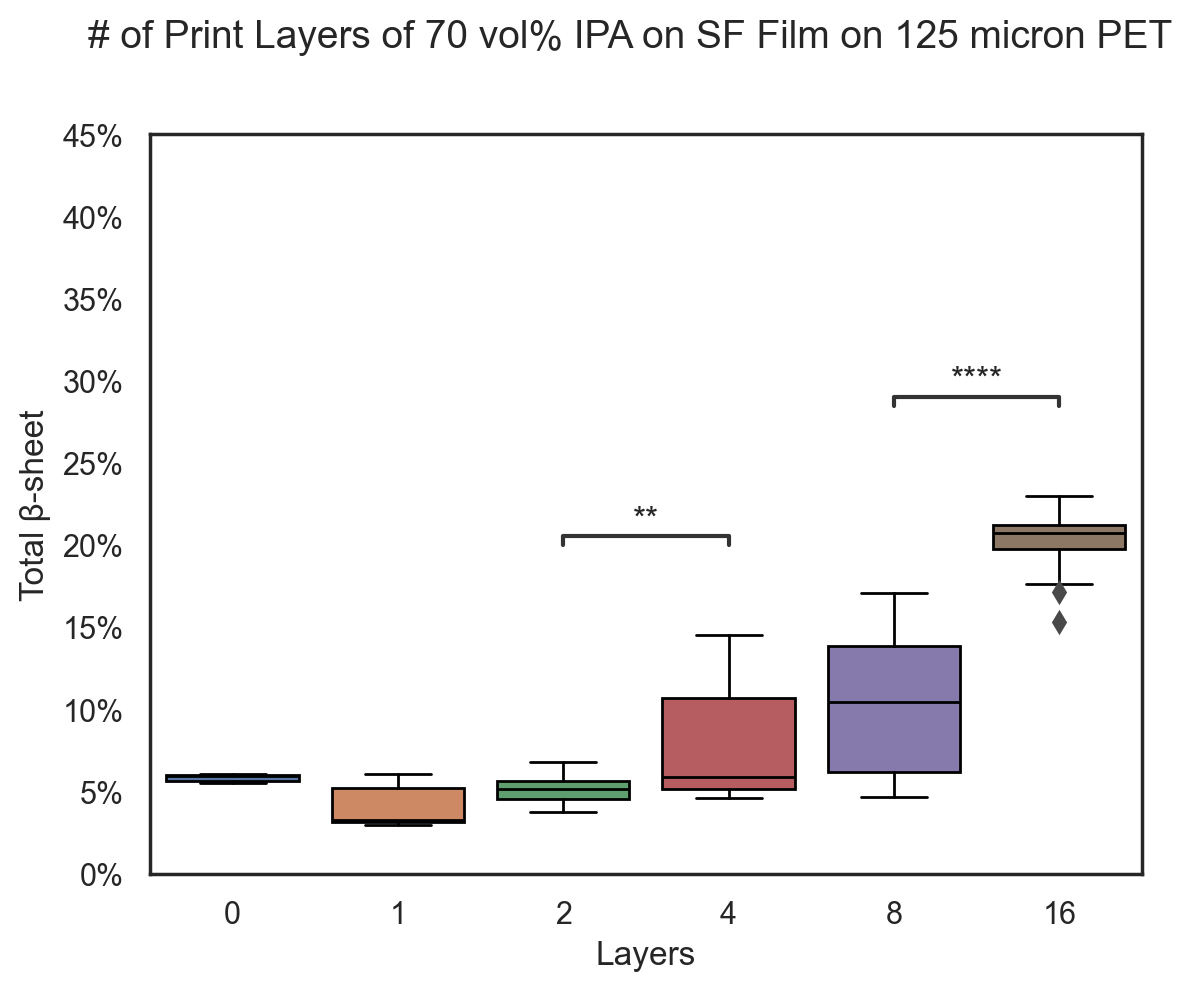

: 

In [41]:
# annot.reset_configuration()
#add comparison between print layers and control to ensure no statistical differences
#should maybe make a df from this instead of my crap?
import string
import seaborn as sns
from scipy.stats import mannwhitneyu, normaltest
#from utils import *

sns.set(rc={"figure.dpi":200, 'savefig.dpi':200})
sns.set_style("white")

from statannotations.Annotator import Annotator
import matplotlib.ticker as mtick
from matplotlib.offsetbox import AnchoredText
Tcleaned_secondarystructs_df = cleaned_secondarystructs_df.T

x= list(Tcleaned_secondarystructs_df["Layers"])
y= list(Tcleaned_secondarystructs_df["Total β-sheet content"])
order = ['0','1','2','4','8','16']
box_pairs = [('2','4'),('4','8'),('8','16')]#,('100','120')]

# formatted_pvalues = [f"p={p:.2e}" for p in pvalues]
# ax = sns.boxplot(data =Tcleaned_secondarystructs_df, x =x, y =y,color=None ,palette=None,linewidth=None, order = order)
PROPS = {
    'boxprops':{'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}}
ax = sns.boxplot( x =x, y =y , order = order,**PROPS,linewidth=1)

# annot = Annotator(ax,pairs = box_pairs, data =Tcleaned_secondarystructs_df, x=x, y =y, order=order)
annot = Annotator(ax,pairs = box_pairs, x=x, y =y, order=order)
annot.reset_configuration()
#annot.configure(test='t-test_welch',loc='inside', verbose=2, show_test_name ='False' ,text_format="simple",comparisons_correction =None,line_height=0.025, text_offset=.025)
#commented line below due to installation issues and not wanting to restart kernel
annot.configure(test='t-test_welch',loc='inside', verbose=1, show_test_name ='false', text_format="star", comparisons_correction ='bonferroni',
                line_height=0.025, text_offset= .25, hide_non_significant = 'false')
# annot.configure(**{**configuration, "text_format":"simple", "text_offset":6})\
#     .apply_test().annotate()
# annot.set_custom_annotations(formatted_pvalues)
annot.apply_test()
ax,test_results = annot.annotate(line_offset_to_group=.25, line_offset=.25)
# StatsText = AnchoredText('test',loc='upper right', prop=dict(size=6), frameon=True)

plt.xlabel("Layers")
plt.ylabel("Total β-sheet")
plt.suptitle('# of Print Layers of ' + str(volpercent) +' vol% ' + solvent + ' on SF Film on 125 micron PET', fontsize=14, y=1, va='top')
#make y axis a percentage
plt.ylim(0.00, 0.45)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax = 1,decimals = 0))
plt.savefig(savefolderpath+'/'+'Box Plot.svg', format='svg')
plt.show()

In [60]:
Tcleaned_secondarystructs_df = cleaned_secondarystructs_df.T

In [86]:
x= list(Tcleaned_secondarystructs_df[Tcleaned_secondarystructs_df["Alcohol"] == 'EtOH']["AlcoholVol%"])
# y= list(Tcleaned_secondarystructs_df["Total β-sheet content"])
y= list(Tcleaned_secondarystructs_df[Tcleaned_secondarystructs_df["Alcohol"] == 'EtOH']["Total β-sheet content"])
x 


['60',
 '60',
 '60',
 '60',
 '60',
 '70',
 '70',
 '70',
 '70',
 '70',
 '80',
 '80',
 '80',
 '80',
 '80',
 '90',
 '90',
 '90',
 '90',
 '90',
 '100',
 '100',
 '100',
 '100',
 '100']

In [85]:
y

[0.2925736879416505,
 0.14589708775013152,
 0.17119208071832287,
 0.26736008943893574,
 0.2510639365550073,
 0.39058003980464745,
 0.39732719402483396,
 0.3842255823787681,
 0.3905673958811613,
 0.3704437864337081,
 0.412409733443091,
 0.40988683725617686,
 0.40916035645572285,
 0.4099828879848063,
 0.4075359978307347,
 0.35203791481567526,
 0.3639768648397692,
 0.35452652472472146,
 0.36208363000834076,
 0.35983963883248526,
 0.1419286555769107,
 0.16827829602032846,
 0.17281284801036167,
 0.16621254079559003,
 0.16899824367562397]

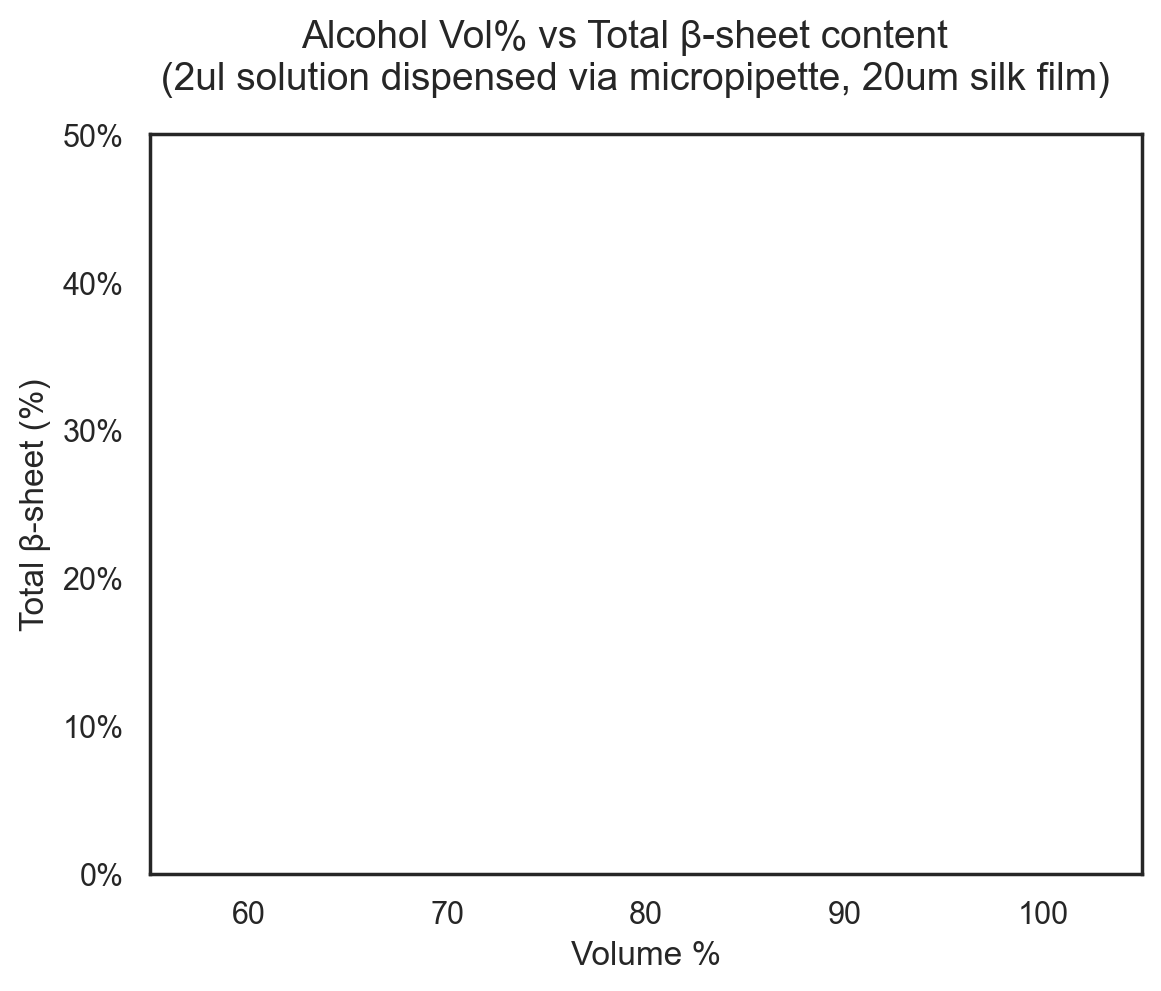

In [83]:
import string
import seaborn as sns
from scipy.stats import mannwhitneyu, normaltest
#from utils import *

sns.set(rc={"figure.dpi":200, 'savefig.dpi':200})
sns.set_style("white")

from statannotations.Annotator import Annotator
import matplotlib.ticker as mtick
from matplotlib.offsetbox import AnchoredText

# x= list(Tcleaned_secondarystructs_df["AlcoholVol%"])
x= list(Tcleaned_secondarystructs_df[Tcleaned_secondarystructs_df["Alcohol"] == 'EtOH']["AlcoholVol%"])
y= list(Tcleaned_secondarystructs_df[Tcleaned_secondarystructs_df["Alcohol"] == 'EtOH']["Total β-sheet content"])
order = [60,70,80,90,100]
box_pairs = [(60,70),(70,80),(80,90),(90,100)]

ax = sns.boxplot(x =x, y =y,color=None ,palette=None,linewidth=None, order = order)
plt.xlabel("Volume %")
plt.ylabel("Total β-sheet (%)")
plt.suptitle('Alcohol Vol% vs Total β-sheet content \n (2ul solution dispensed via micropipette, 20um silk film)', fontsize=14, y=1, va='top')
#make y axis a percentage
plt.ylim(0, 0.5)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax = 1,decimals = 0))
# plt.savefig(savefolderpath+'/'+'Box Plot without annot stats.svg', format='svg')
plt.show()


In [ ]:
a = "side"
y= "Total β-sheet content"
bx = sns.boxplot(data =Tcleaned_secondarystructs_df, x =a, y =y,color=None ,palette=None,linewidth=None)
plt.suptitle('Side of substrate vs Total β-sheet content \n (15wt% solution, lab convection oven, treated PET substrate)', fontsize=14, y=1, va='top')
#make y axis a percentage
plt.ylim(0.1, 0.15)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax = 1,decimals = 0))
plt.xlabel("Side of Film")
plt.savefig(savefolderpath+'/'+'Side-based Box Plot.svg', format='svg')
plt.show()

In [ ]:
# import scipy.stats
# # F,p = scipy.stats.f_oneway(df_of_total_beta_sheet[df_of_total_beta_sheet["Condition"]=='37C WA']['total beta-sheet'],
# # df_of_total_beta_sheet[df_of_total_beta_sheet["Condition"]=='As Dried']['total beta-sheet'],
# # df_of_total_beta_sheet[df_of_total_beta_sheet["Condition"]=='MeOH Immersion']['total beta-sheet'])

# #ax.set_xlabel('200nm Spuncoat Film Treatment, n=3 per treatment' +'\n'+str(testresults))
# #ax.set_xlabel('Film Treatment, n=6 per treatment' +'\n'+"1-Way ANOVA P value:" + "{:.2e}".format(p))  #+ '\n' +"Groups compared with 1 way pairwise T-test with Bonferroni correction:"+
# # '\n'+  "37C WA vs As Dried:  \u03B1 0.05"+'\n'+"37C WA vs As Dried: asdf \u03B1 0.05"+'\n' +"37C WA vs As Dried: asdf \u03B1 0.05")
# # #ax.ylabel('%', fontweight ='bold', fontsize = 15)

# #ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))

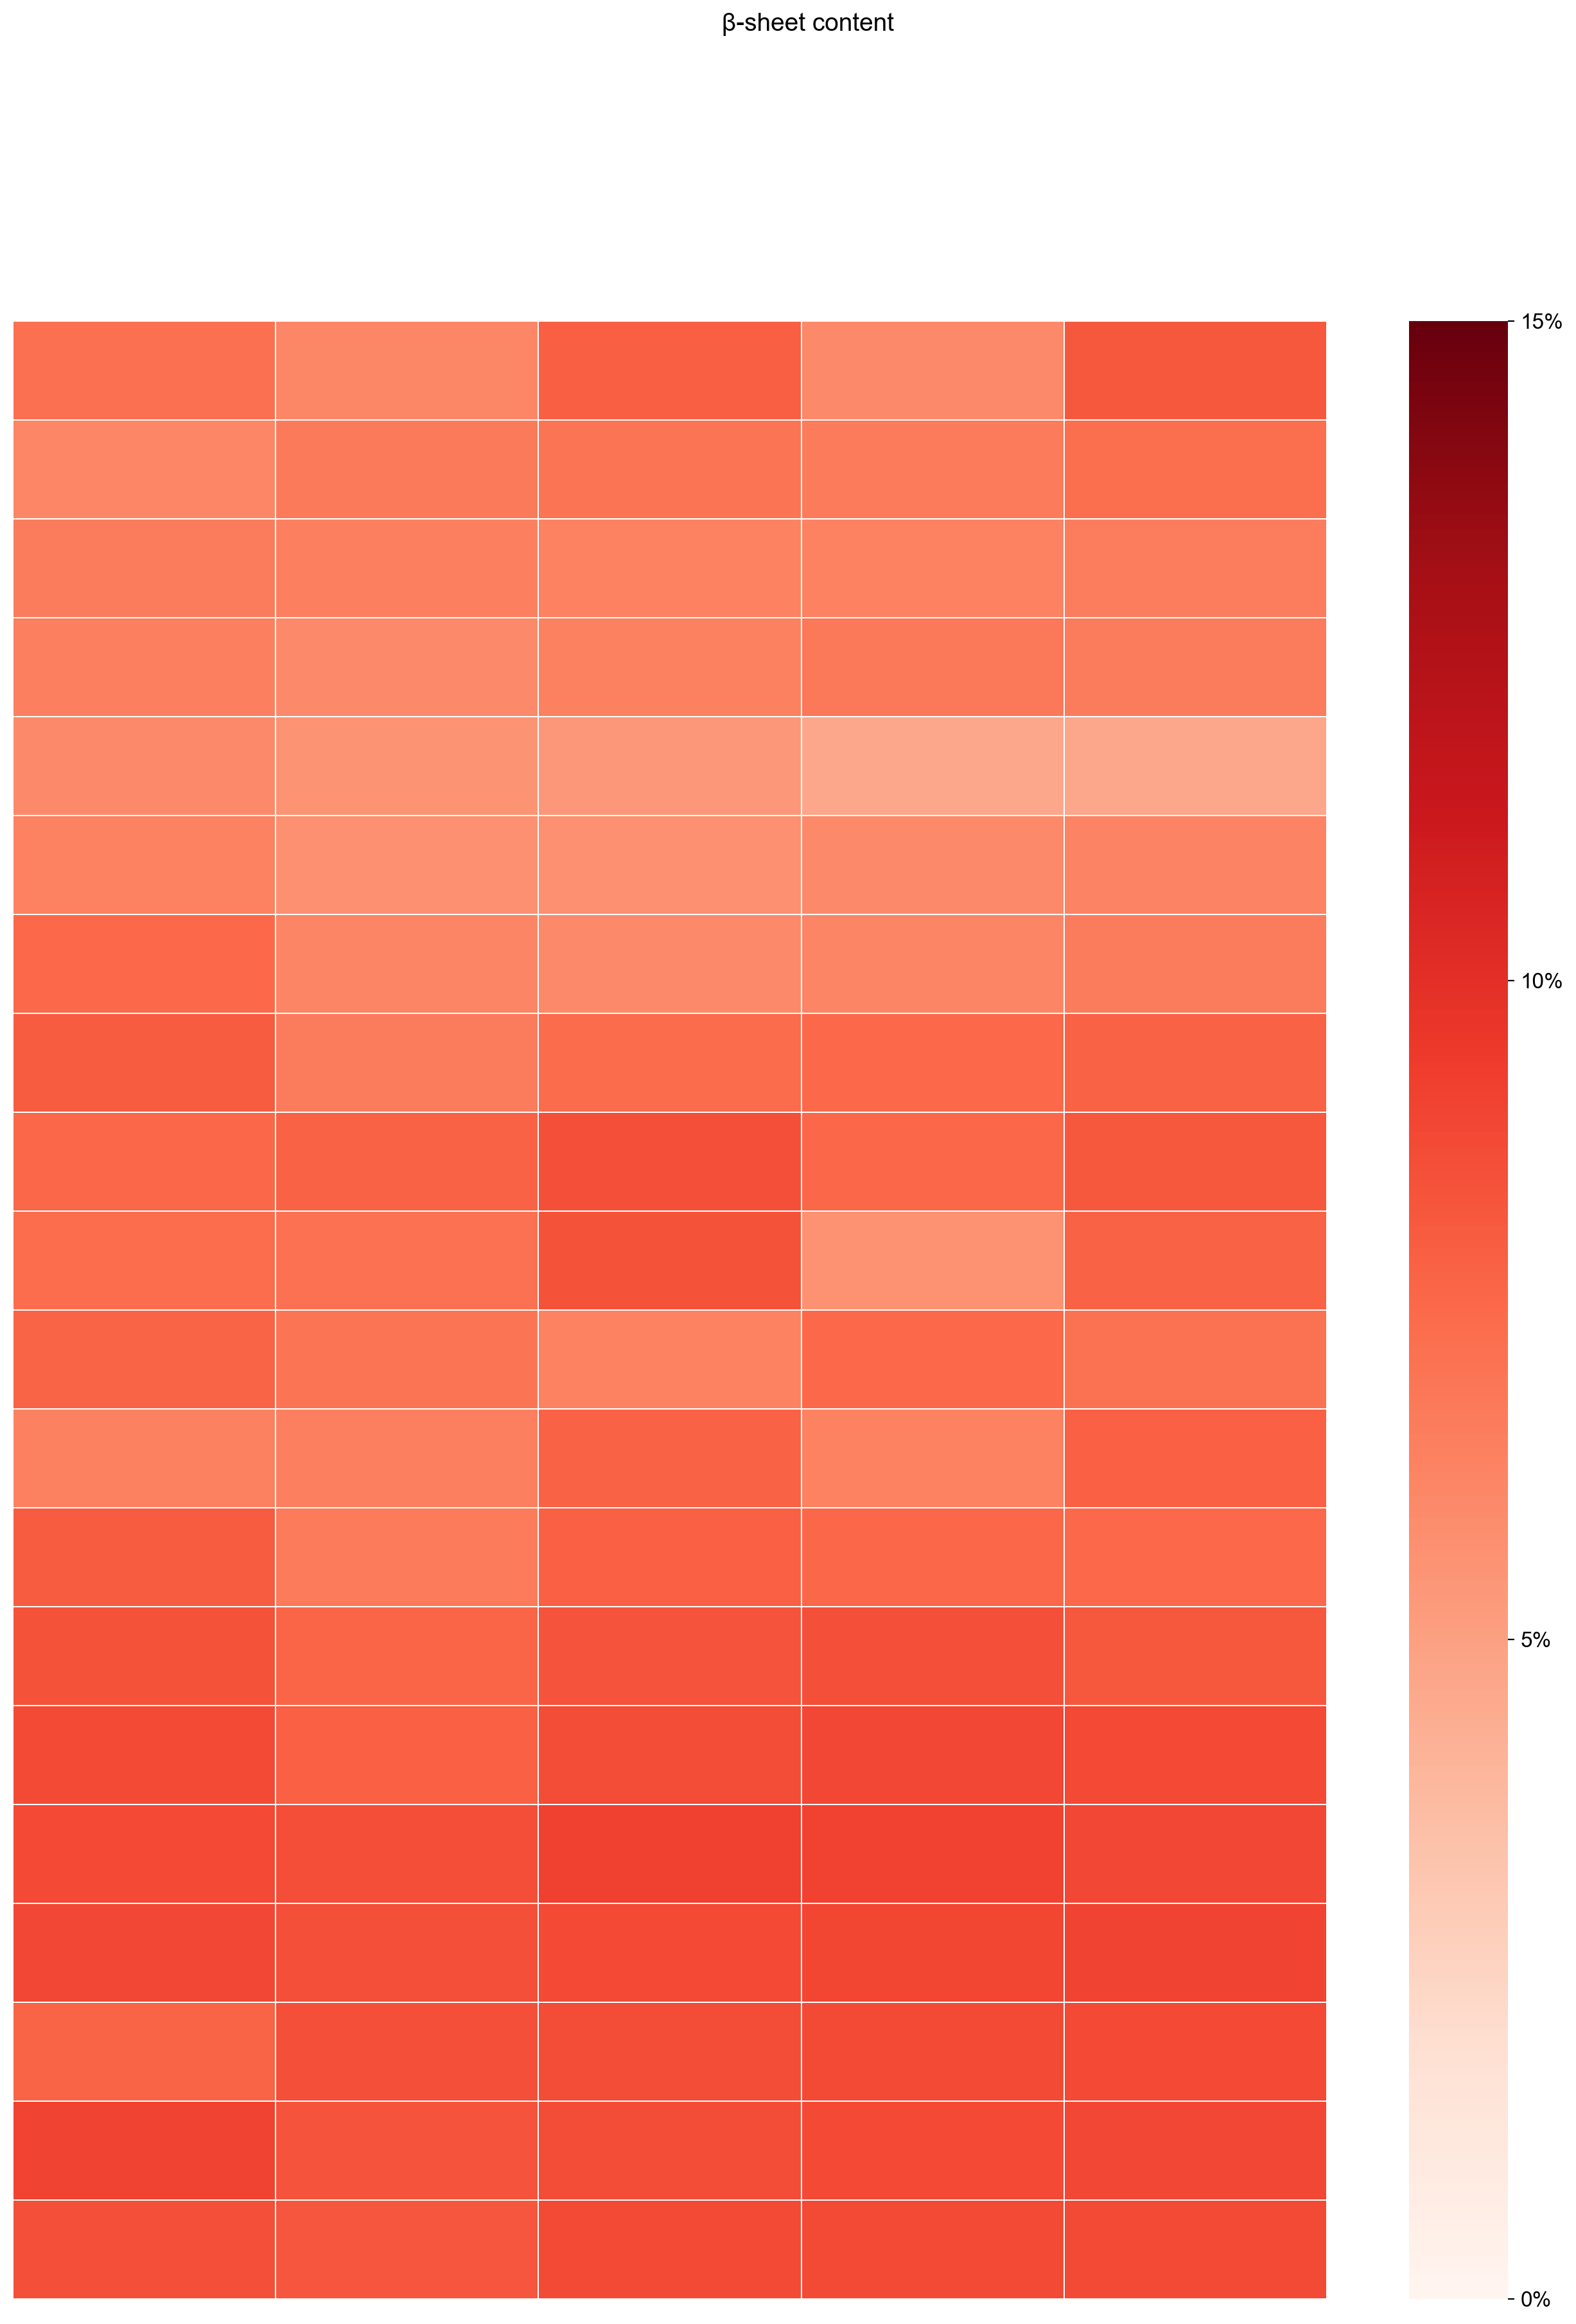

In [25]:
# heatmap via seaborn, plotted from 0 to 15% beta sheet content:
plt.figure(figsize=(num_in_x*3.3, num_in_y), dpi=200)

# save beta sheet content into csv; if from single microscopy file, use the shape of the data as it is; if it's from multiple files, save it with the header
fullcsvname = (savefolderpath+'/'+'Total_betasheet_Array.csv')
np.savetxt(fullcsvname, break_total_beta_percent, fmt='%.4f', delimiter=',')

hmtitletext = ('\u03B2-sheet content' + "\n")
ax_example = sns.heatmap(break_total_beta_percent[0:(
    num_in_y)], cmap="Reds", vmin=0, vmax=0.15, linewidths=.05, xticklabels=False, yticklabels=False)


plt.suptitle(hmtitletext, fontsize=14, y=1, va='top')
fig.subplots_adjust(hspace=.2, wspace=.2)
# ax_example.invert_yaxis()
cbar = ax_example.collections[0].colorbar
cbar.set_ticks([0,.05, 0.1,.15]) #, 0.3, .4, .5])
cbar.set_ticklabels(['0%', '5%', '10%','15%' ])# '30%', '40%', '50%'])
fullfigname = (savefolderpath+'/'+'HeatmapWhiteToRed0to15.svg')
plt.savefig(fullfigname)
plt.show()

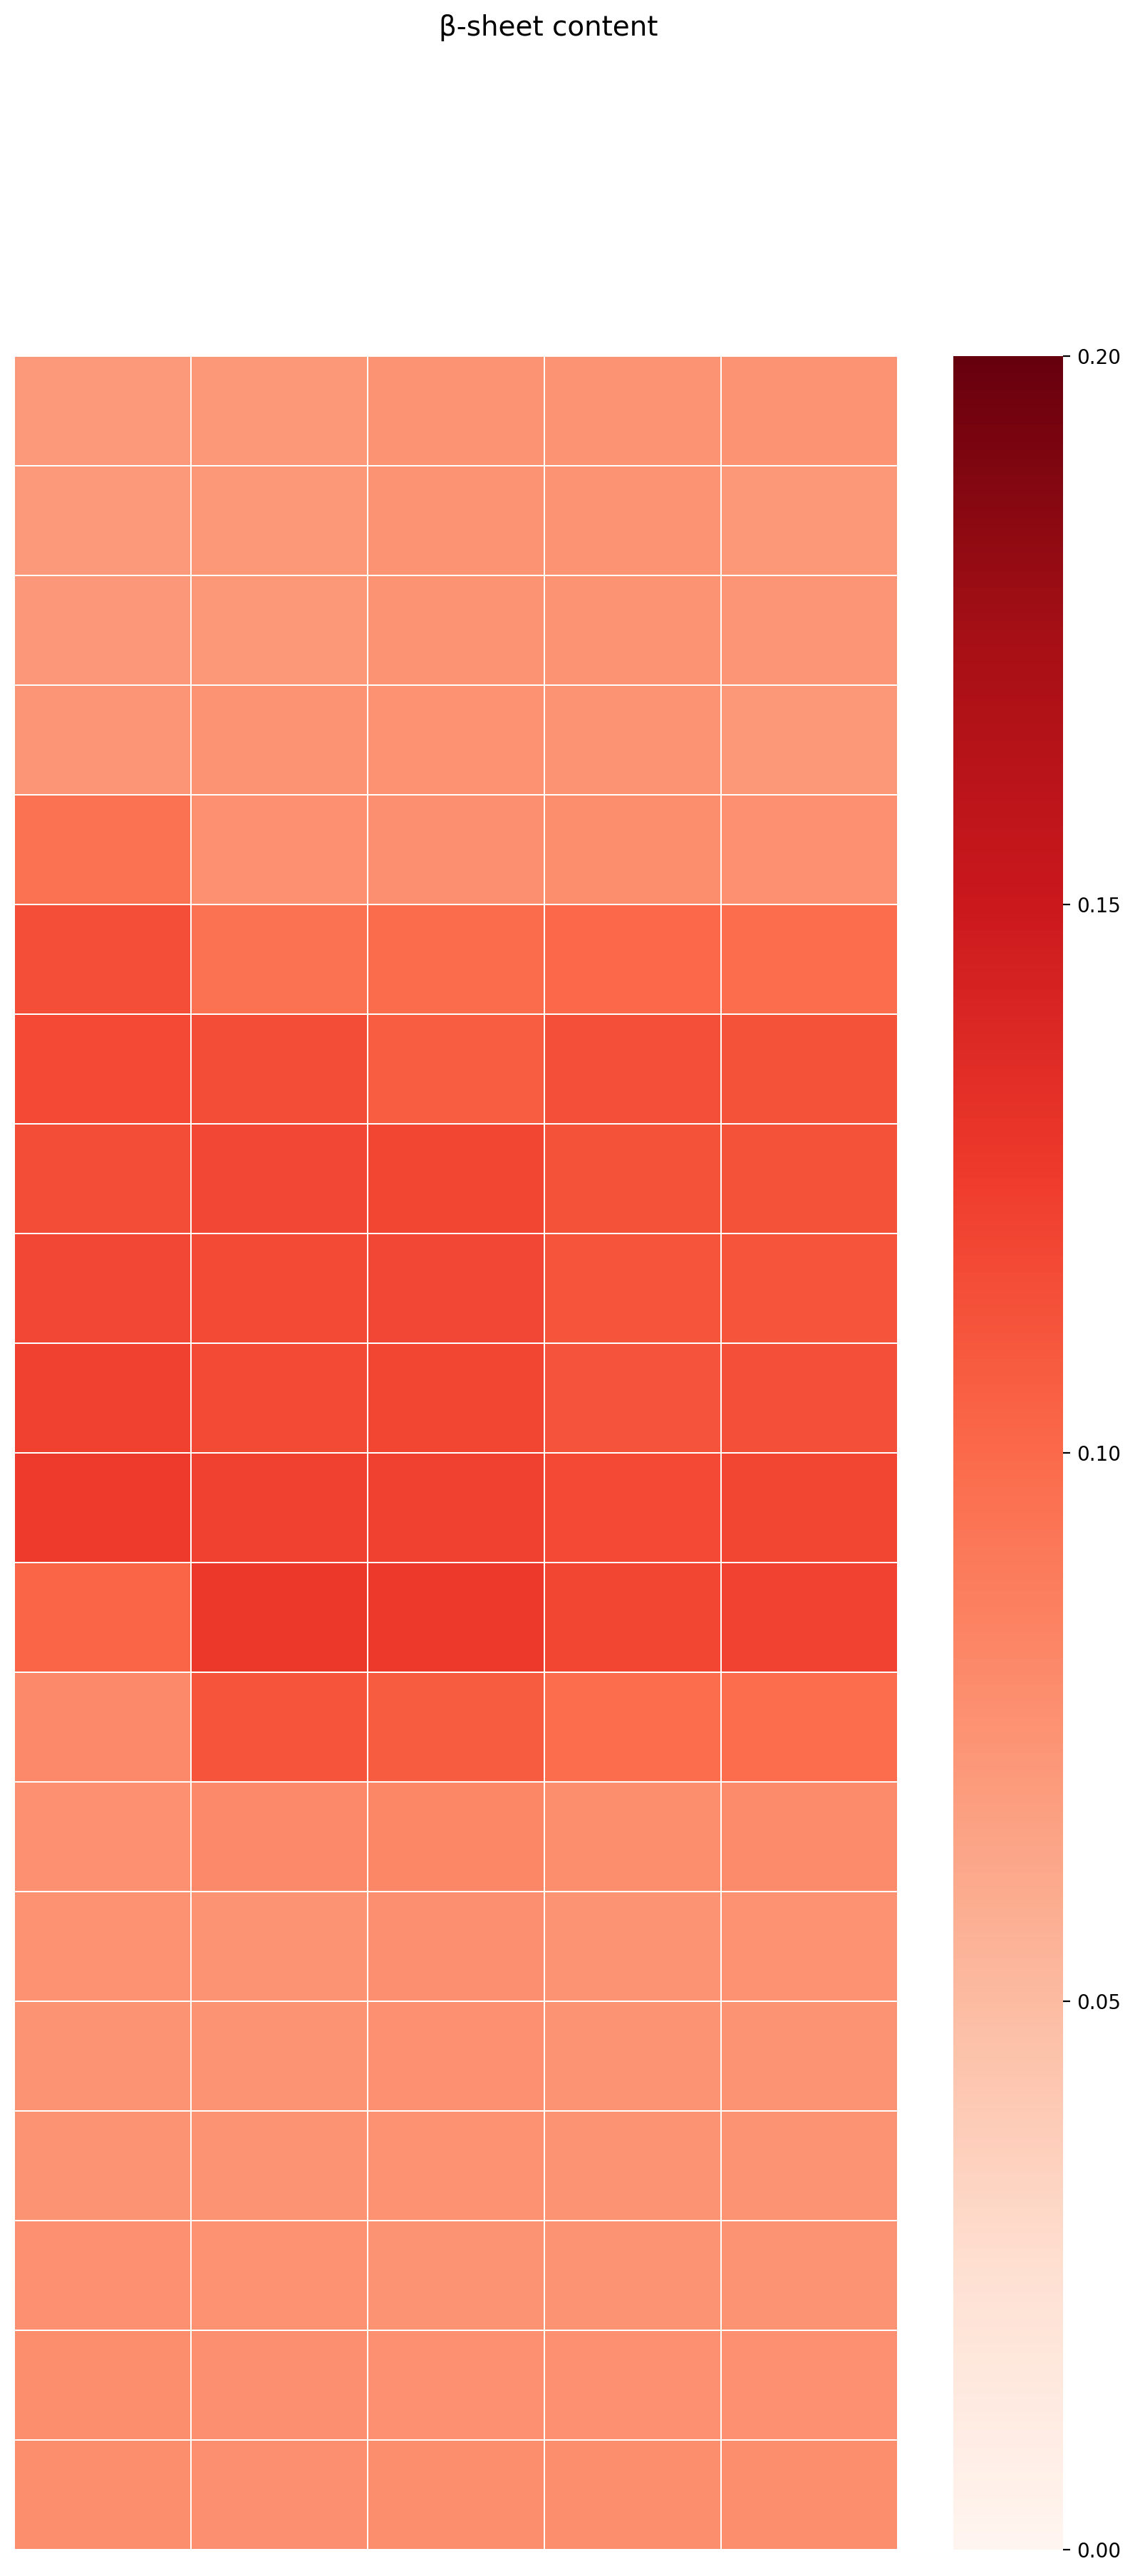

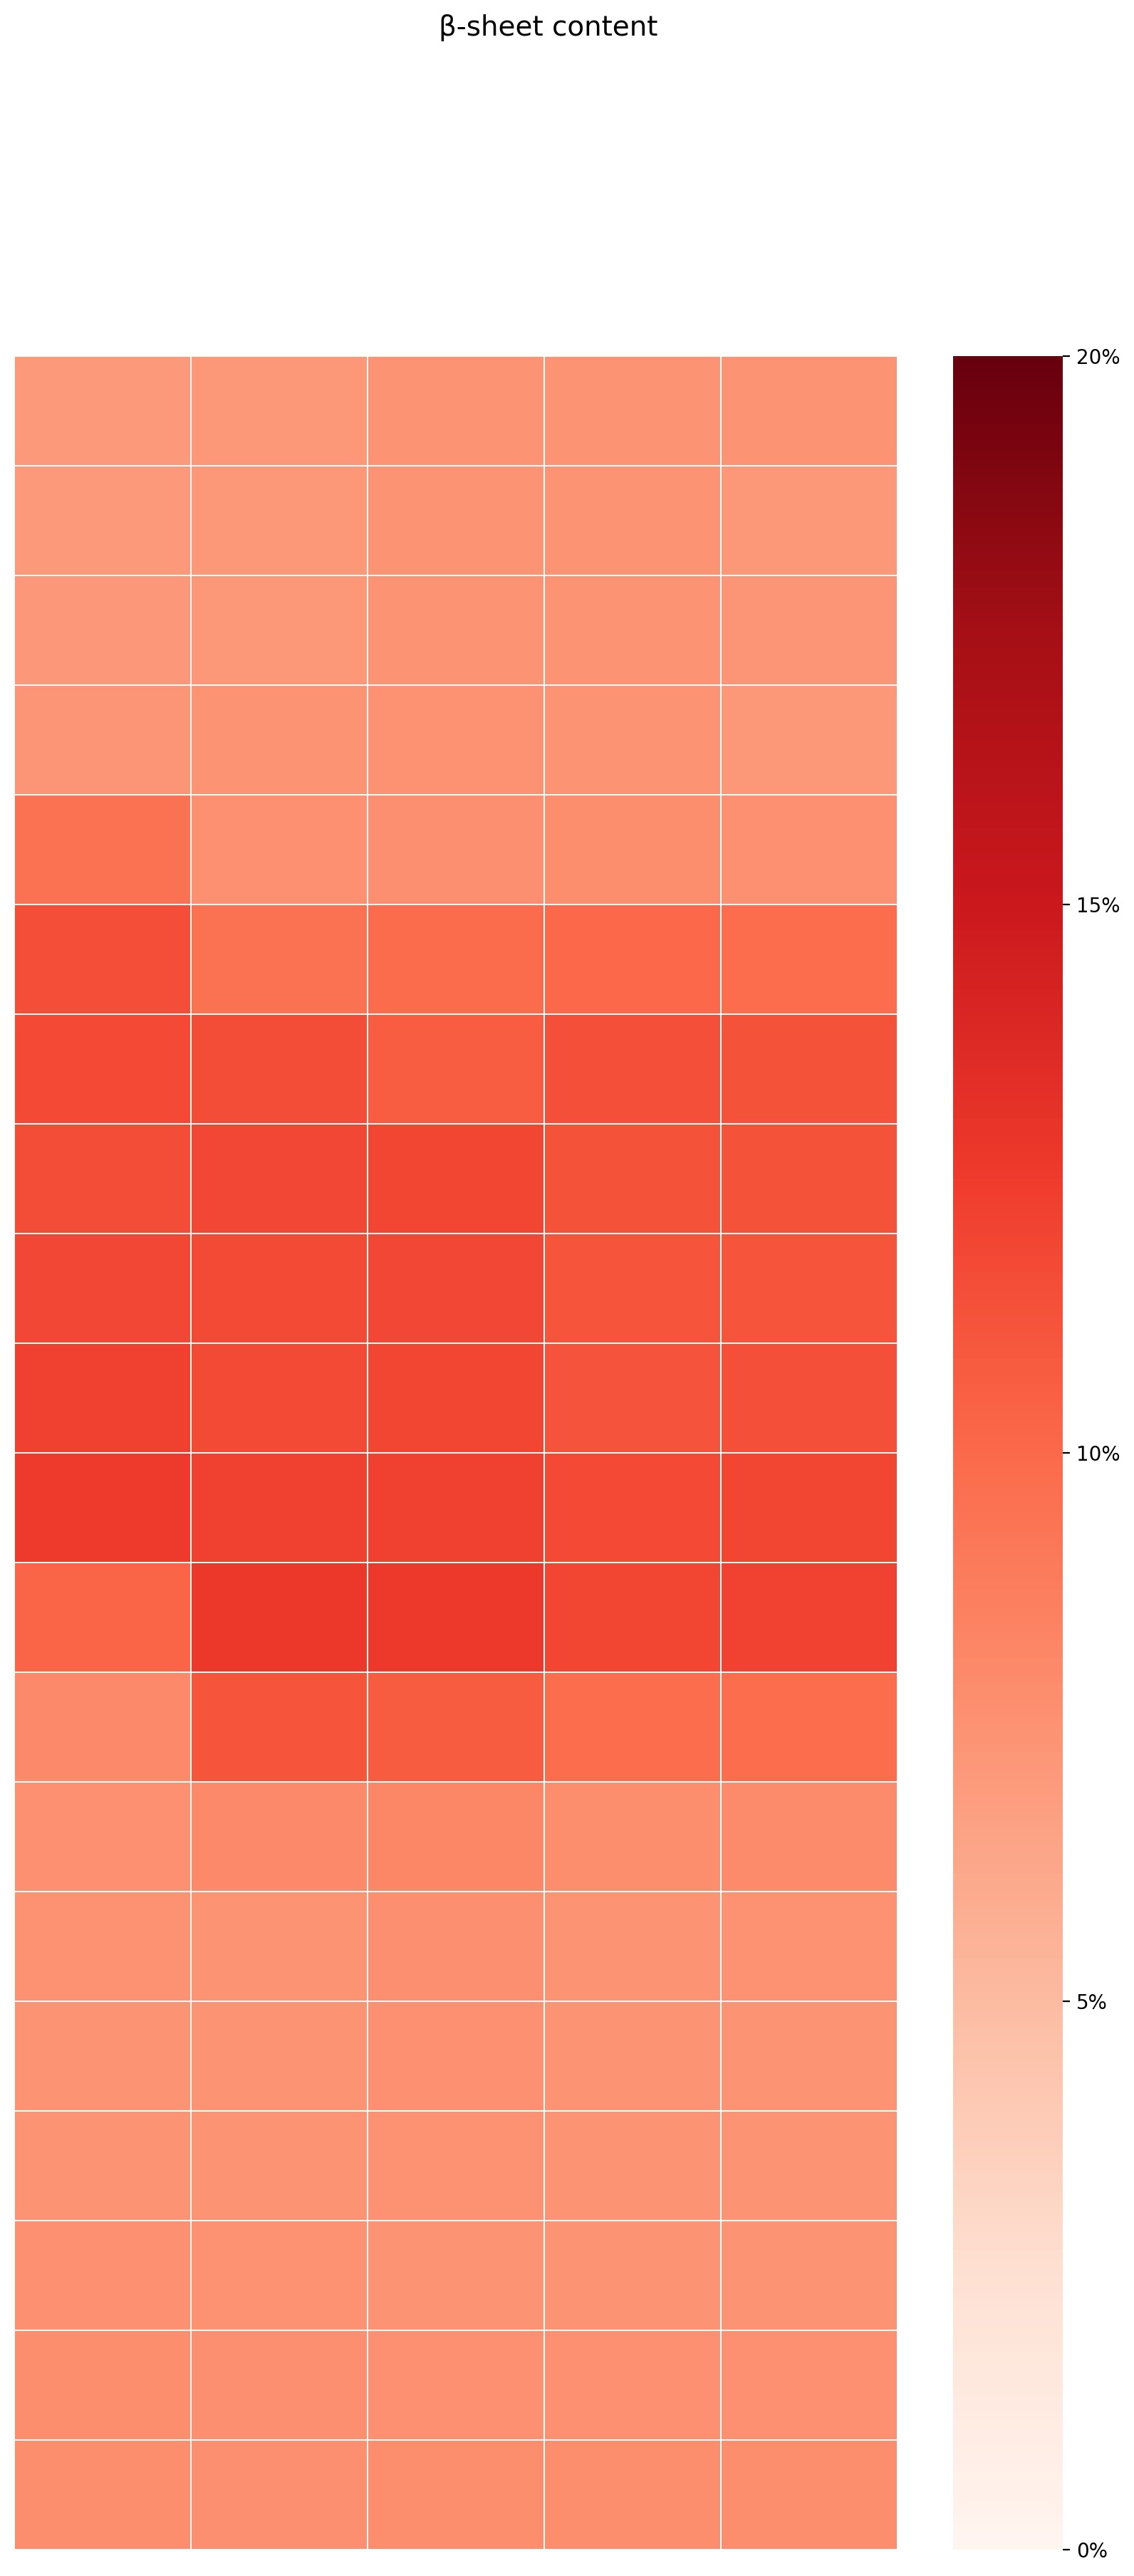

In [54]:
# heatmap via seaborn, plotted from 0 to 20% beta sheet content:
plt.figure(figsize=(num_in_x*2, num_in_y), dpi=200)

# save beta sheet content into csv; if from single microscopy file, use the shape of the data as it is; if it's from multiple files, save it with the header
fullcsvname = (savefolderpath+'/'+'Total_betasheet_Array.csv')
np.savetxt(fullcsvname, break_total_beta_percent, fmt='%.4f', delimiter=',')

hmtitletext = ('\u03B2-sheet content' + "\n")
ax_example = sns.heatmap(break_total_beta_percent[0:(
    num_in_y)], cmap="Reds", vmin=0, vmax=0.2, linewidths=.05, xticklabels=False, yticklabels=False)


plt.suptitle(hmtitletext, fontsize=14, y=1, va='top')
fig.subplots_adjust(hspace=.2, wspace=.2)
# ax_example.invert_yaxis()
cbar = ax_example.collections[0].colorbar
cbar.set_ticks([0,.05, 0.1,.15, 0.2]) #, 0.3, .4, .5])
cbar.set_ticklabels(['0%', '5%', '10%','15%' ,'20%'])# '30%', '40%', '50%'])
fullfigname = (savefolderpath+'/'+'HeatmapWhiteToRed0to20.svg')
plt.savefig(fullfigname)
plt.show()

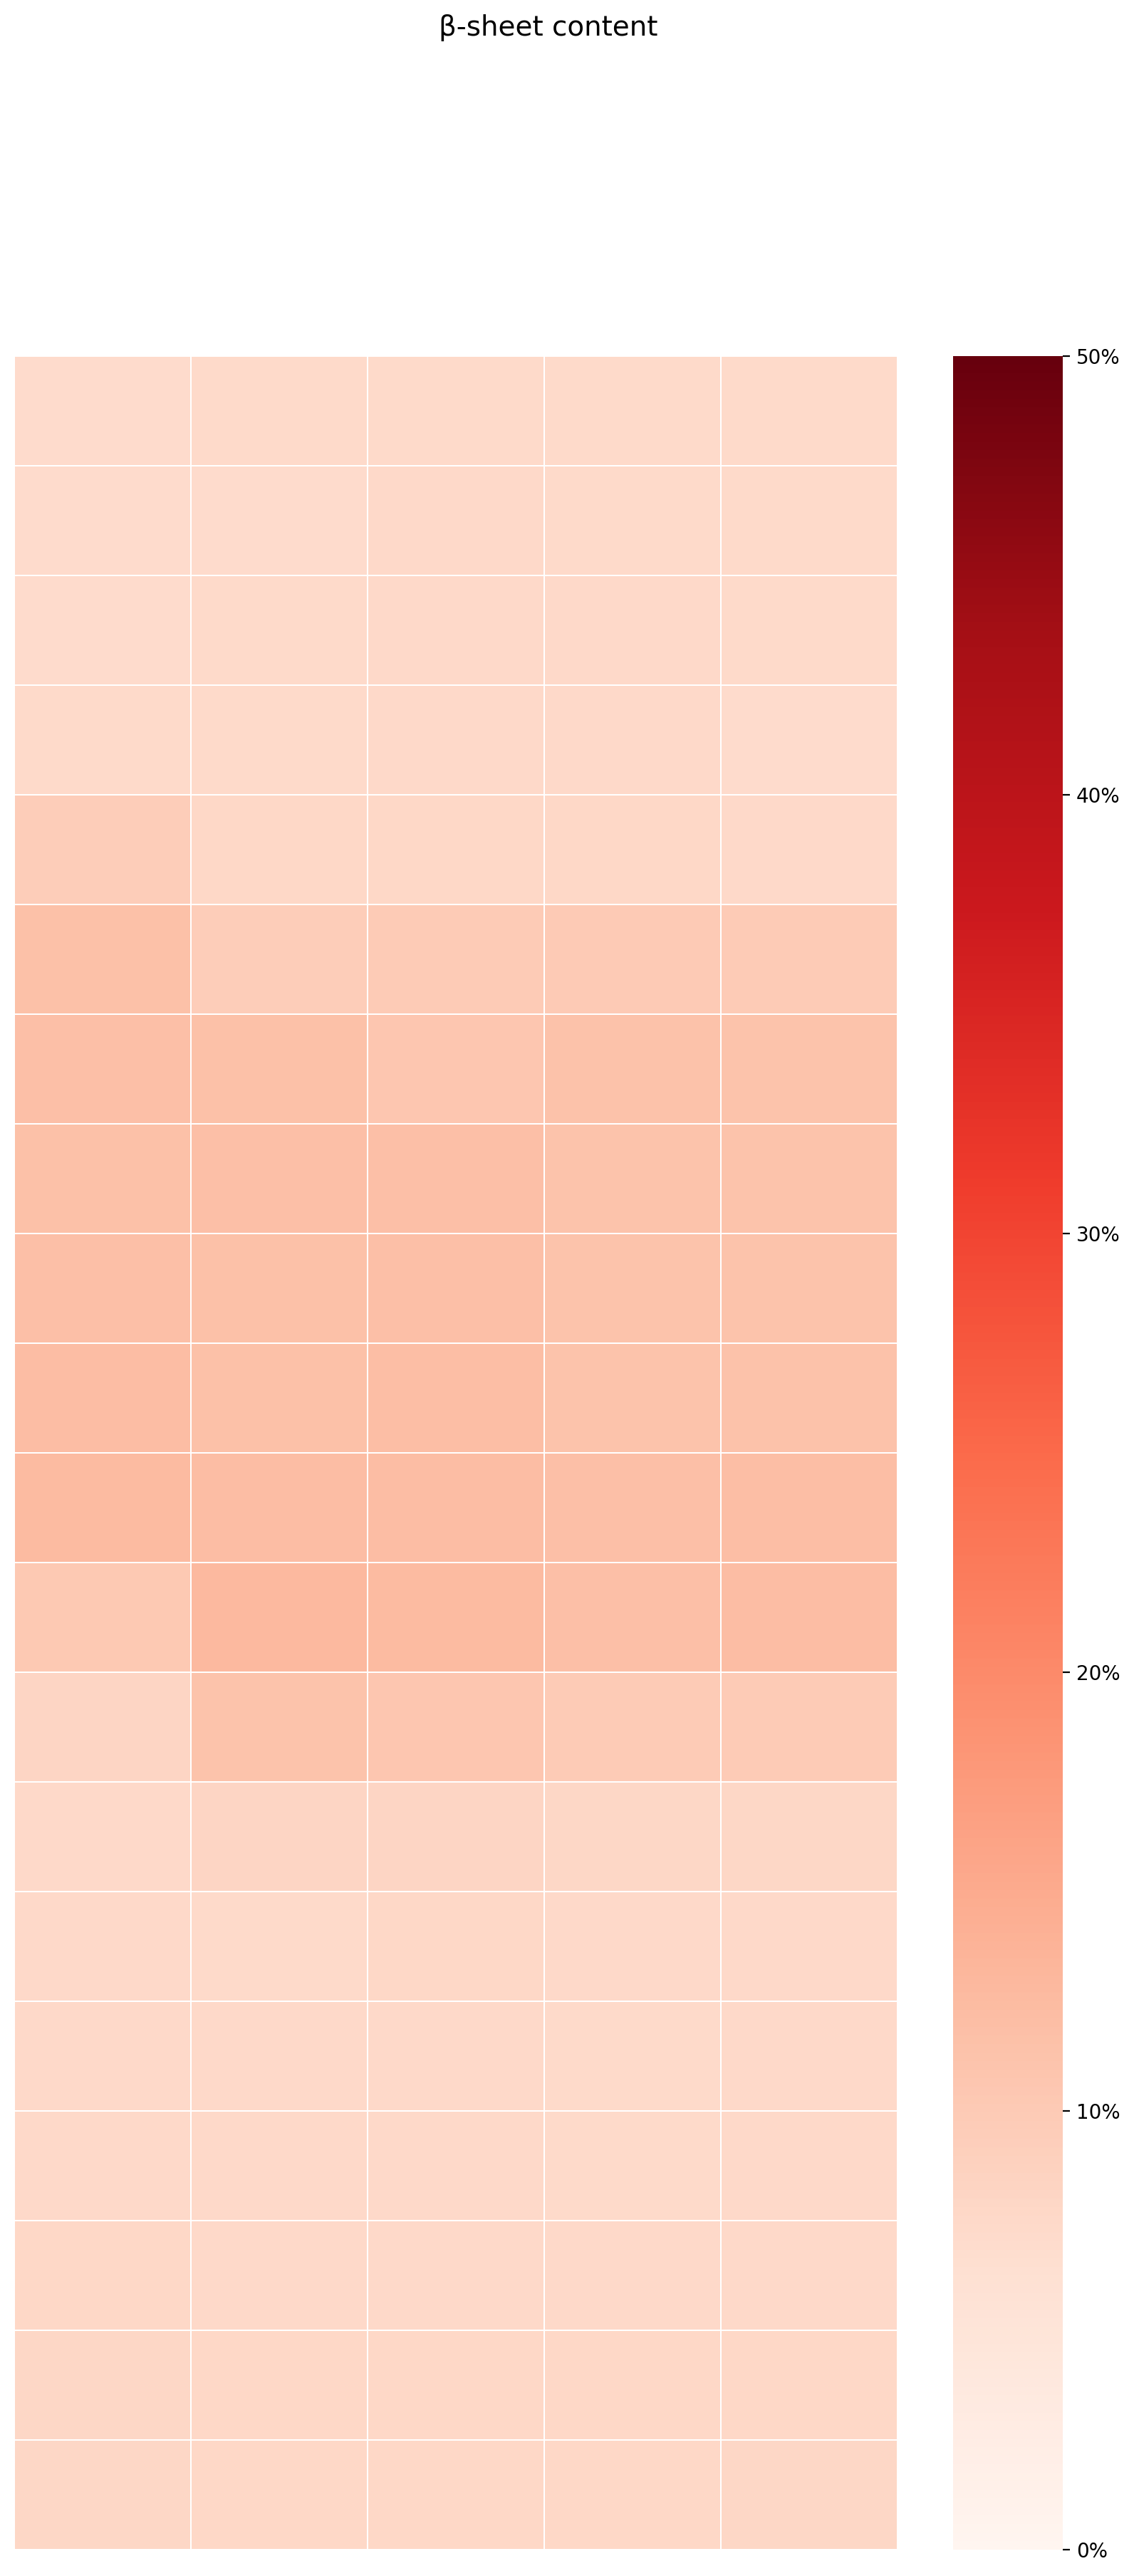

In [52]:
# heatmap via seaborn, plotted from 0 to 50% beta sheet content:
plt.figure(figsize=(num_in_x*2, num_in_y), dpi=200)

# save beta sheet content into csv; if from single microscopy file, use the shape of the data as it is; if it's from multiple files, save it with the header
fullcsvname = (savefolderpath+'/'+'Total_betasheet_Array.csv')
np.savetxt(fullcsvname, break_total_beta_percent, fmt='%.4f', delimiter=',')

hmtitletext = ('\u03B2-sheet content' + "\n")
ax_example = sns.heatmap(break_total_beta_percent[0:(
    num_in_y)], cmap="Reds", vmin=0, vmax=0.5, linewidths=.05, xticklabels=False, yticklabels=False)


plt.suptitle(hmtitletext, fontsize=14, y=1, va='top')
fig.subplots_adjust(hspace=.2, wspace=.2)
# ax_example.invert_yaxis()
cbar = ax_example.collections[0].colorbar
cbar.set_ticks([0, 0.1, 0.2, 0.3, .4, .5])
cbar.set_ticklabels(['0%', '10%', '20%','30%', '40%', '50%'])
plt.show()

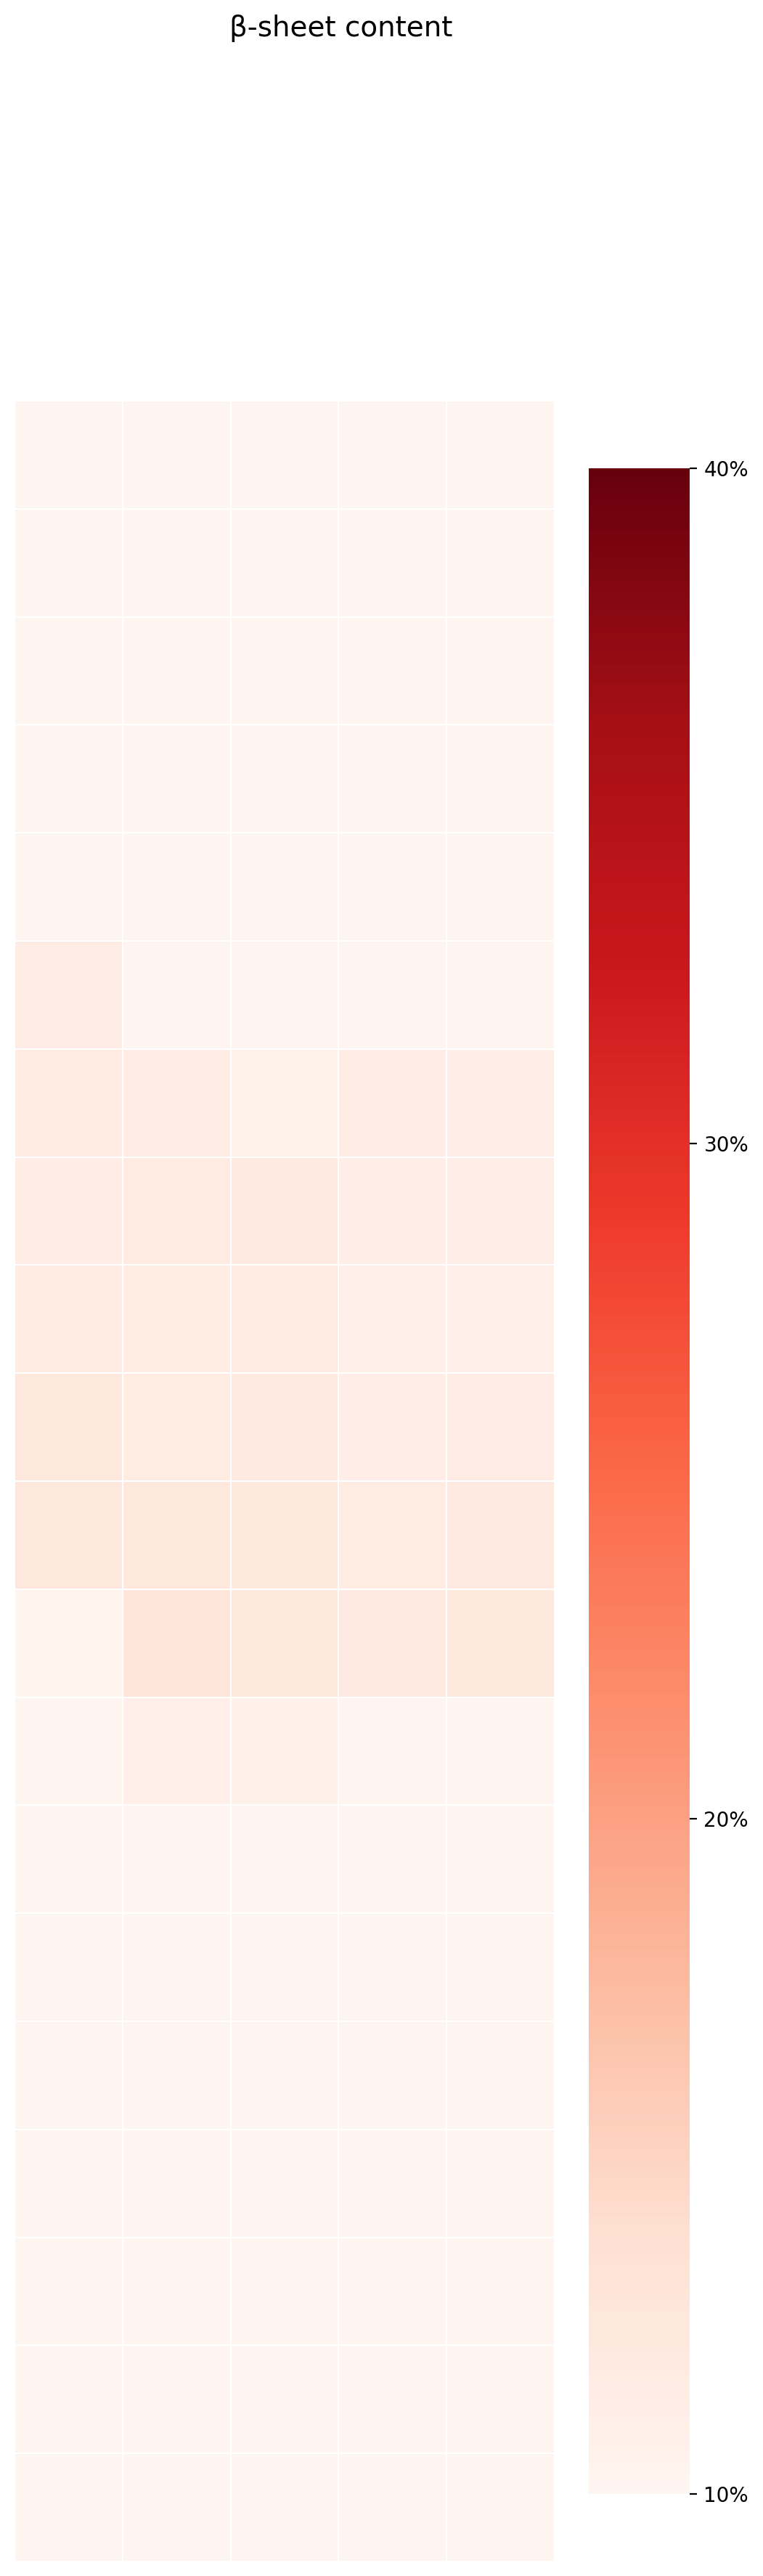

In [46]:
# heatmap via seaborn, plotted from 10 to 40% beta sheet content:
vmin = 0.1
vmax = 0.4

plt.figure(figsize=(num_in_x*1.2, num_in_y), dpi=200)

hmtitletext = ('\u03B2-sheet content' + "\n")
ax_example = sns.heatmap(break_total_beta_percent[0:(num_in_y)], cmap="Reds", vmin=vmin, vmax=vmax, linewidths=.05,
                         square=True, xticklabels=False, yticklabels=False)
#sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=True)
plt.suptitle(hmtitletext, fontsize=14, y=1, va='top')
fig.subplots_adjust(hspace=.2, wspace=.2)
# ax_example.invert_yaxis()
cbar = ax_example.collections[0].colorbar
cbar.set_ticks([0.1, 0.2, 0.3, .4])
cbar.set_ticklabels(['10%', '20%', '30%', '40%'])

fullfigname = (savefolderpath+'/'+'HeatmapWhiteToRed10to40.png')
plt.savefig(fullfigname)
plt.show()

In [ ]:
# heatmap via seaborn, plotted from 10 to 50% beta sheet content blue to yellow to red:
plt.figure(figsize=(num_in_x*1.2, num_in_y), dpi=200)

hmtitletext = ('\u03B2-sheet content' + "\n")
ax_example = sns.heatmap(break_total_beta_percent[0:(num_in_x)], cmap="RdYlBu_r", vmin=0.10, vmax=0.5, linewidths=.05,
                         square=True, xticklabels=False, yticklabels=False)
#sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=True)
plt.suptitle(hmtitletext, fontsize=14, y=1, va='top')
fig.subplots_adjust(hspace=.2, wspace=.2)
# ax_example.invert_yaxis()
cbar = ax_example.collections[0].colorbar
cbar.set_ticks([0.1, 0.2, 0.3, .4, .5])
cbar.set_ticklabels(['10%', '20%', '30%', '40%', '50%'])

fullfigname = (savefolderpath+'/'+'HeatmapBlueYellowRed10to50.png')
plt.savefig(fullfigname)


In [42]:
# Heatmap with GUI to input range of y bar and color option

# Jeff 3.20.2023

# Modified from https://www.geeksforgeeks.org/python-tkinter-entry-widget/

import math
root = tk.Tk()

# setting the windows size
root.geometry("450x150")
root.eval('tk::PlaceWindow . center')
root.wm_attributes('-topmost', True)
# root.lift()

# declaring numerical variables for storing x and y values
y_min = tk.IntVar()
y_max = tk.IntVar()
y_interval = tk.IntVar()

# defining a function that will get x and y values and close the window


def submit():
    global user_message_entry, num_y_min, num_y_max, num_y_interval
    # t = Toplevel(root)
    num_y_min = int(y_min.get())
    num_y_max = int(y_max.get())
    num_y_interval = int(y_interval.get())

    #print("Total number of spectra: " + str(num_in_x*num_in_y))
    time.sleep(0.5)
    root.destroy()


# creating a label for y_min using widget Label
y_min_label = tk.Label(
    root, text='Minimum beta-sheet value (in %): ', font=('calibre', 10, 'bold'))

# creating a entry for input of y_min using widget Entry
y_min_entry = tk.Entry(root, textvariable=y_min,
                       font=('calibre', 10, 'normal'))

# creating a label for y_max using widget Label
y_max_label = tk.Label(
    root, text='Maximum beta-Sheet Value (in %)  : ', font=('calibre', 10, 'bold'))

# creating a entry for y_max using widget Entry
y_max_entry = tk.Entry(root, textvariable=y_max,
                       font=('calibre', 10, 'normal'))

# creating a label for y_interval using widget Label
y_interval_label = tk.Label(
    root, text='Interval for Beta Sheet (in %, should be divisible ): ', font=('calibre', 10, 'bold'))

# creating a entry for y_interval using widget Entry
y_interval_entry = tk.Entry(
    root, textvariable=y_interval, font=('calibre', 10, 'normal'))

# creating a button using the widget button that will call the submit function
sub_btn = tk.Button(root, text='Submit', command=lambda: submit())

# placing the label and entry in the required position using grid method
y_min_label.grid(row=0, column=0)
y_min_entry.grid(row=0, column=1)
y_max_label.grid(row=1, column=0)
y_max_entry.grid(row=1, column=1)
y_interval_label.grid(row=2, column=0)
y_interval_entry.grid(row=2, column=1)
sub_btn.grid(row=3, column=1)

# performing an infinite loop for the window to display
root.mainloop()

# heatmap via seaborn with automatically changing intensity axis
plt.figure(figsize=(num_in_x*1.2, num_in_y), dpi=200)

# generate mininum and maximum values for colorscale by rounding to the nearest "10", then going down for min and up for max
vminimum = num_y_min/100  # math.floor(min(total_beta_percent)*10)/10
vmaximum = num_y_max/100  # math.ceil(max(total_beta_percent)*10)/10
vinterval = num_y_interval/100
hmtitletext = ('\u03B2-sheet content' + "\n")
ax_example = sns.heatmap(break_total_beta_percent[0:(num_in_y)], cmap="Reds", vmin=vminimum, vmax=vmaximum, linewidths=.05,
                         xticklabels=False, yticklabels=False, square=True)
plt.suptitle(hmtitletext, fontsize=12, y=1, va='top')
fig.subplots_adjust(hspace=.2, wspace=.365)

# ax_example.invert_yaxis()
cbar = ax_example.collections[0].colorbar
l = np.arange(vminimum, vmaximum+.1, 0.1)
print('l', l)
l1 = ["%.1f" % member for member in l*100]
print('l1', l1)
cbar.set_ticks(l)
l2 = ["%.0f" % member for member in l*100]
l3 = list(map("{}%".format, l2))
cbar.set_ticklabels(l3)

# save heatmap into file
fullfigname = (savefolderpath+'/'+'HeatmapWhitetoRedCustomFitScalebar.png')
plt.savefig(fullfigname)

l [0.  0.1 0.2 0.3]
l1 ['0.0', '10.0', '20.0', '30.0']


In [44]:
# heatmap via seaborn with automatically changing intensity axis
import math
plt.figure(figsize=(num_in_x*2, num_in_y), dpi=200)

# generate mininum and maximum values for colorscale by rounding to the nearest "10", then going down for min and up for max
vminimum = math.floor(min(total_beta_percent)*10)/10
print('vmin', vminimum)
vmaximum = math.ceil(max(total_beta_percent)*10)/10
print('vmax', vmaximum)
hmtitletext = ('\u03B2-sheet content' + "\n")
ax_example = sns.heatmap(break_total_beta_percent[0:(num_in_y)], cmap="Reds", vmin=vminimum, vmax=vmaximum, linewidths=.05,
                         xticklabels=False, yticklabels=False, square=True)
plt.suptitle(hmtitletext, fontsize=12, y=1, va='top')
fig.subplots_adjust(hspace=.2, wspace=.365)

# ax_example.invert_yaxis()
cbar = ax_example.collections[0].colorbar
l = np.arange(vminimum, vmaximum+.1, 0.1)
print('l', l)
l1 = ["%.1f" % member for member in l*100]
print('l1', l1)
cbar.set_ticks(l)
l2 = ["%.0f" % member for member in l*100]
l3 = list(map("{}%".format, l2))
cbar.set_ticklabels(l3)

# save heatmap into file
fullfigname = (savefolderpath+'/'+'HeatmapWhitetoRedAutoFitScalebar.png')
plt.savefig(fullfigname)

vmin 0.0
vmax 0.2
l [0.  0.1 0.2 0.3]
l1 ['0.0', '10.0', '20.0', '30.0']


In [ ]:
# heatmap via seaborn, plotted from 10 to 50% beta sheet content from white to red:
# (plot from CSV to fix bad scan values)


plt.figure(figsize=(num_in_x*2, num_in_y), dpi=200)

hmtitletext = ('\u03B2-sheet content' + "\n")

ax_example = sns.heatmap(data_from_csv, cmap="Reds", vmin=0.10, vmax=0.5, linewidths=.05,
                         square=True, xticklabels=False, yticklabels=False)
#sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=True)
plt.suptitle(hmtitletext, fontsize=12, y=1, va='top')
fig.subplots_adjust(hspace=.2, wspace=.365)

# ax_example.invert_yaxis()
cbar = ax_example.collections[0].colorbar
cbar.set_ticks([0.1, 0.2, 0.3, .4, .5])
cbar.set_ticklabels(['10%', '20%', '30%', '40%', '50%'])

fullfigname = (savefolderpath+'/'+'CleanedHeatmapWhiteToRed10to50.png')
plt.savefig(fullfigname)


#Statistics (not finished so stop here)

In [ ]:
# crreate Mean,
total_beta_sheet_df['5min.0']

In [ ]:
# plot beta sheet concentration vs time
fig, ax = plt.subplots(figsize=(20, 10), constrained_layout=True)

titletext = ('\u03B2-sheet content vs Water Annealing Temperature and Time')
fig.suptitle(titletext, fontsize=16, y=1.05, va='top')
ax.plot(total_beta_sheet_df.columns, total_beta_percent, label='60C')

plt.show()


In [ ]:
# list_total_beta_sheet= []
# list_AHRC=[]
# list_beta_turn = []
# for i in range(len(structs)):
#     list_total_beta_sheet.append(structs[i]['aggregate \u03B2-strand/\u03B2-sheet']+structs[i]['intermolecular \u03B2-sheets (weak)'])
#     list_AHRC.append(structs[i]['random coils + \u03B1 helices'])
#     list_beta_turn.append(structs[i]['\u03B2-turns'])
# #list_total_beta_sheet[:]


# edge_list = ['MeOH No UV']*3
# inside_list = ['MeOH then 10hrUV']*3
# condition_list = [*edge_list,*inside_list]#inside_list.extend(outside_list)

# combinedConditionBetadict = {'Condition':condition_list,'total beta-sheet': list_total_beta_sheet}
# combinedConditionRCAHdict = {'Condition':condition_list,'random coil/alpha helix': list_AHRC}
# combinedConditionBetaTurndict = {'Condition':condition_list,'beta-turn': list_beta_turn}

# df_of_total_beta_sheet = pd.DataFrame(combinedConditionBetadict)
# df_of_AHRC = pd.DataFrame(combinedConditionRCAHdict)
# df_of_beta_turn = pd.DataFrame(combinedConditionBetaTurndict)
# #combinedConditionBetadict


In [ ]:
# # Make a paired t-test (or ANOVA 1 way + bonferonni correction plots for multiple comparisons) with p-value/significance displayed for total beta sheet
# import string
# import seaborn as sns
# sns.set(rc={"figure.dpi":200, 'savefig.dpi':200})
# sns.set_style("white")
# from statannot import add_stat_annotation
# import matplotlib.ticker as mtick

# order = ['MeOH No UV','MeOH then 10hrUV']
# box_pairs = [('MeOH No UV','MeOH then 10hrUV')]
# #beta sheet total
# ax = sns.boxplot(data =df_of_total_beta_sheet, x =df_of_total_beta_sheet['Condition'],
# y = df_of_total_beta_sheet["total beta-sheet"],order=order,color=None ,palette=None,linewidth=None)

# testresults = add_stat_annotation(ax, x = df_of_total_beta_sheet['Condition'],
# y = df_of_total_beta_sheet["total beta-sheet"],test='t-test_ind', text_format='star',
# loc='outside', verbose=2, box_pairs = box_pairs, comparisons_correction =None,
# order = order)

# StatsText = AnchoredText('test',loc='upper right', prop=dict(size=6), frameon=True)
# # ax.add_artist(StatsText)
# # Titletext  = ('p-value')
# # #plt.title('Mean WRFv3.5 LHF', fontsize=40)
# # fig.suptitle(titletext, fontsize=18,y=1.15, va='top')

# import scipy.stats
# # F,p = scipy.stats.f_oneway(df_of_total_beta_sheet[df_of_total_beta_sheet["Condition"]=='37C WA']['total beta-sheet'],
# # df_of_total_beta_sheet[df_of_total_beta_sheet["Condition"]=='As Dried']['total beta-sheet'],
# # df_of_total_beta_sheet[df_of_total_beta_sheet["Condition"]=='MeOH Immersion']['total beta-sheet'])

# #ax.set_xlabel('200nm Spuncoat Film Treatment, n=3 per treatment' +'\n'+str(testresults))
# #ax.set_xlabel('Film Treatment, n=6 per treatment' +'\n'+"1-Way ANOVA P value:" + "{:.2e}".format(p))  #+ '\n' +"Groups compared with 1 way pairwise T-test with Bonferroni correction:"+
# # '\n'+  "37C WA vs As Dried:  \u03B1 0.05"+'\n'+"37C WA vs As Dried: asdf \u03B1 0.05"+'\n' +"37C WA vs As Dried: asdf \u03B1 0.05")
# # #ax.ylabel('%', fontweight ='bold', fontsize = 15)

# ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))
# plt.show()
# testresults
